In [86]:
import sys
sys.dont_write_bytecode = True

# uncomment load_ext line when you initially use the file, after you can comment to get rid of the warning that'll show up
# %load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_processing import prepData, transformData
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score # for finding r2 and MSE
from sklearn.inspection import partial_dependence
import shap
import itertools
from IPython.display import clear_output

path = '../data/bike.csv'
df = pd.read_csv(path, encoding_errors='ignore', parse_dates=['Date'], dayfirst=True)
pd.set_option('display.max_columns', None) # lets you scroll if your monitor isn't wide enough

df = prepData(df)
display(df)

cv = KFold(n_splits=5, shuffle=True, random_state=1) # for cross validation

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import ExtraTreesRegressor

# pulled from modeling file
reg = LinearRegression()
tree = ExtraTreesRegressor(max_depth=7,min_samples_leaf=3,min_samples_split=2,n_estimators=363, random_state=1)

Rented Bike Count  Temperature(C)  Humidity(%)  Wind Speed(m/s)  \
Date                                                                          
2017-12-01               9539       -2.454167    45.875000         1.537500   
2017-12-02               8523        1.325000    61.958333         1.712500   
2017-12-03               7222        4.875000    81.541667         1.612500   
2017-12-04               8729       -0.304167    52.500000         3.450000   
2017-12-05               8307       -4.458333    36.416667         1.108333   
...                       ...             ...          ...              ...   
2018-11-26              17162        6.320833    70.500000         1.029167   
2018-11-27              16282        7.066667    68.000000         1.350000   
2018-11-28              16524        5.304167    25.791667         1.695833   
2018-11-29              16423        3.304167    38.000000         1.212500   
2018-11-30              16297        2.762500    47.208333         1.433333   

            Solar Radiation(MJ/m2)  Rainfall(mm)  Snowfall(mm)  Spring  \
Date                                                                     
2017-12-01                    1.16           0.0           0.0       0   
2017-12-02                    1.12           0.0           0.0       0   
2017-12-03                    0.69           4.0           0.0       0   
2017-12-04                    1.17           0.1           0.0       0   
2017-12-05                    0.64           0.0           0.0       0   
...                            ...           ...           ...     ...   
2018-11-26                    1.74           0.0          29.0       0   
2018-11-27                    0.87           0.0           0.0       0   
2018-11-28                    1.86           0.0           0.0       0   
2018-11-29                    0.64           0.0           0.0       0   
2018-11-30                    1.83           0.0           0.0       0   

            Summer  Autumn  Winter  Weekend  Summer*Temp  
Date                                                      
2017-12-01       0       0       1        0         -0.0  
2017-12-02       0       0       1        1          0.0  
2017-12-03       0       0       1        1          0.0  
2017-12-04       0       0       1        0         -0.0  
2017-12-05       0       0       1        0         -0.0  
...            ...     ...     ...      ...          ...  
2018-11-26       0       1       0        0          0.0  
2018-11-27       0       1       0        0          0.0  
2018-11-28       0       1       0        0          0.0  
2018-11-29       0       1       0        0          0.0  
2018-11-30       0       1       0        0          0.0  

[353 rows x 13 columns]

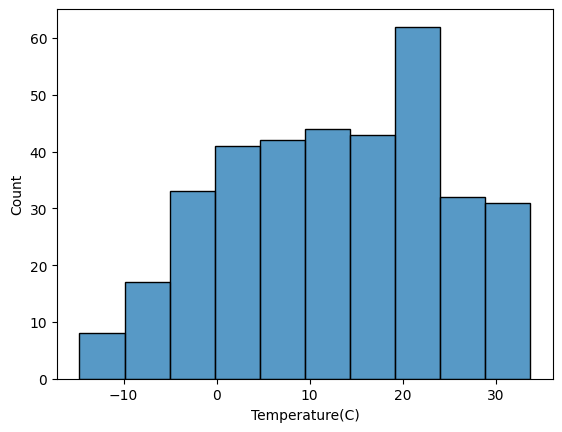

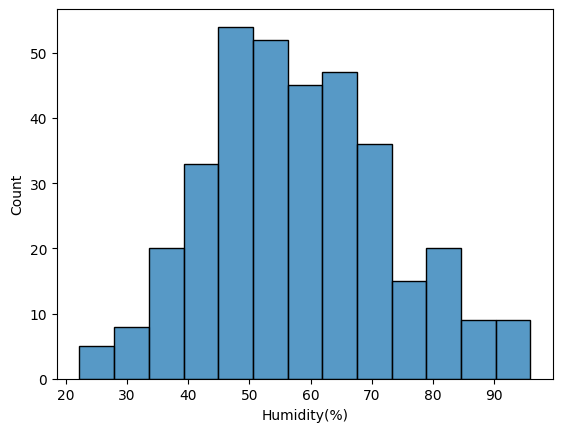

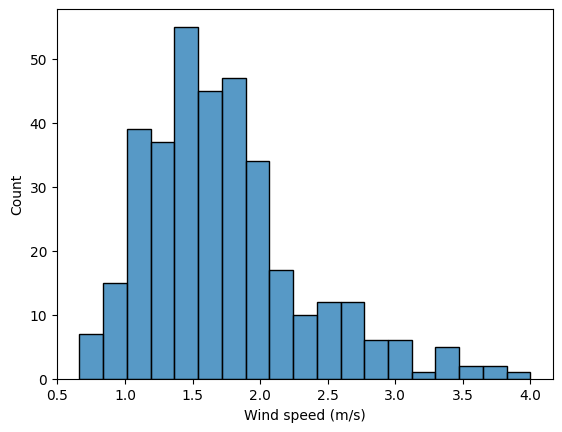

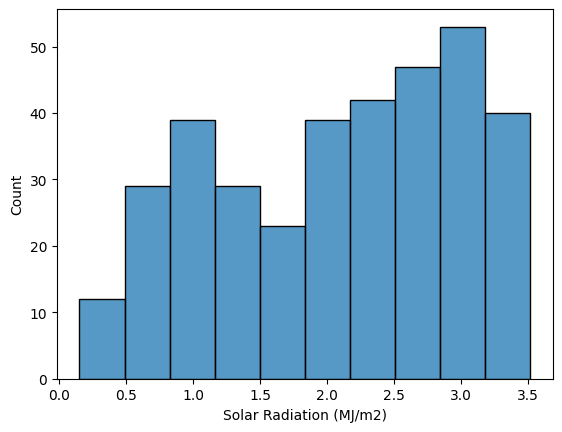

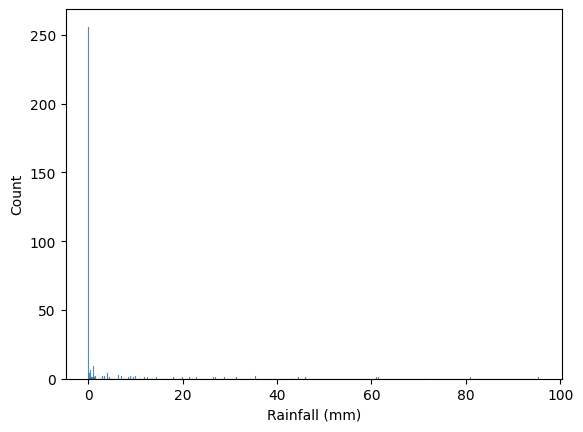

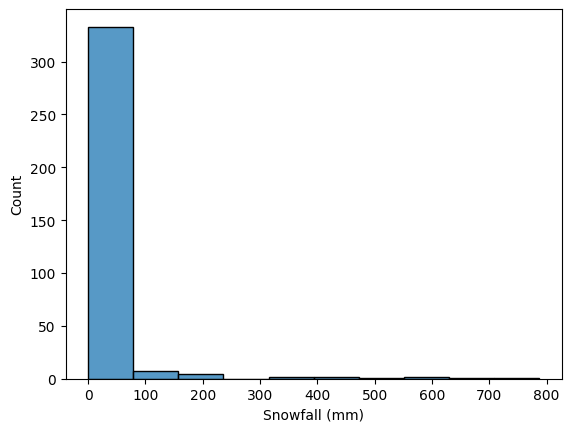

In [ ]:
cols = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(m/s)', 'Solar Radiation(MJ/m2)', 'Rainfall(mm)', 'Snowfall(mm)']
for col in cols:
	sns.histplot(df[col])
	plt.show()

In [87]:
y = df['Rented Bike Count'].to_numpy() # target value
X = df.drop('Rented Bike Count', axis=1) # taking out the target value

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle=True, random_state=1)

# X_train, X_test, y_train, y_test = transformData(X_train, X_test, y_train, y_test)
# X_train = pd.DataFrame(X_train, columns=X.columns) # so we can visualize everything nicely
# X_test = pd.DataFrame(X_test, columns=X.columns) # so we can visualize everything nicely

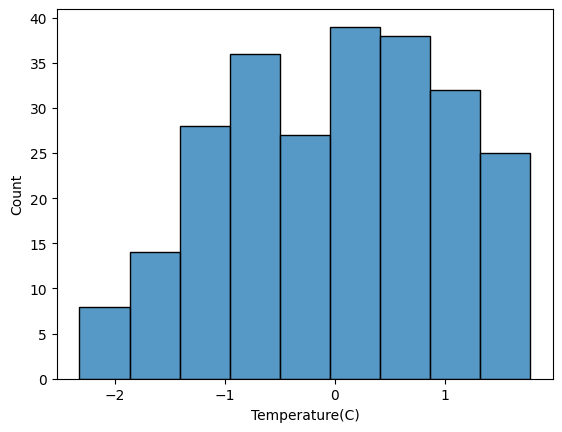

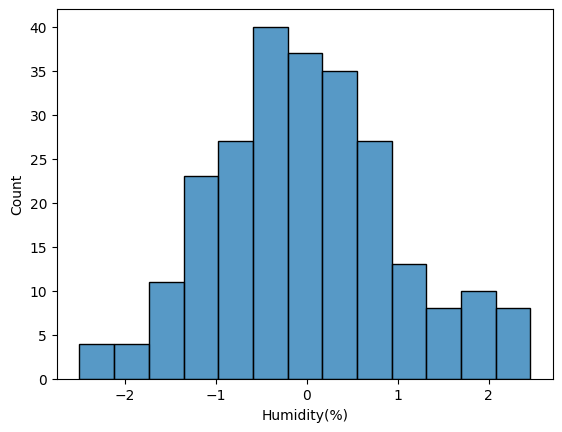

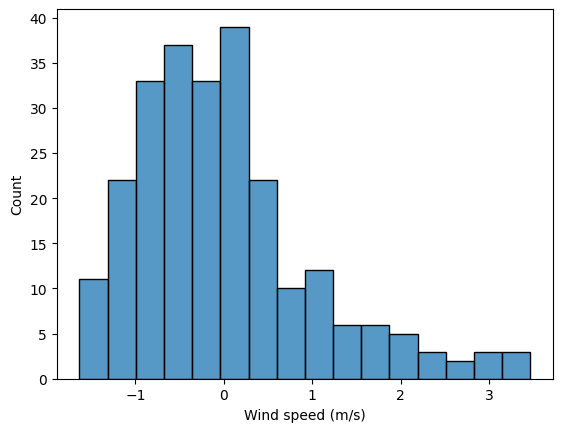

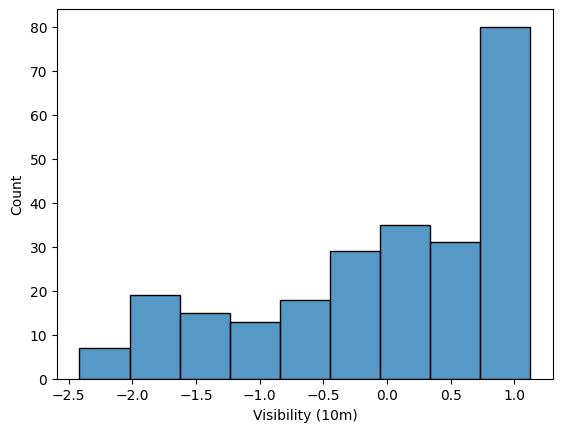

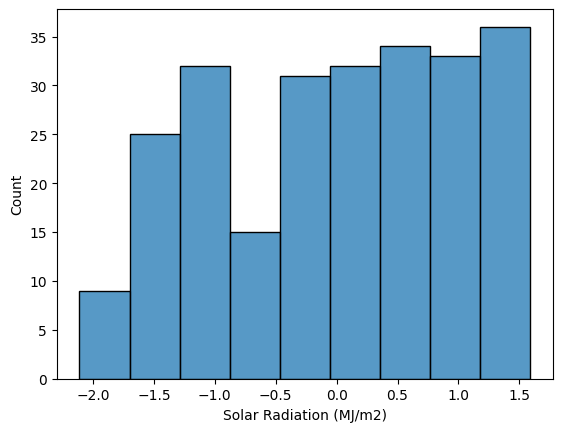

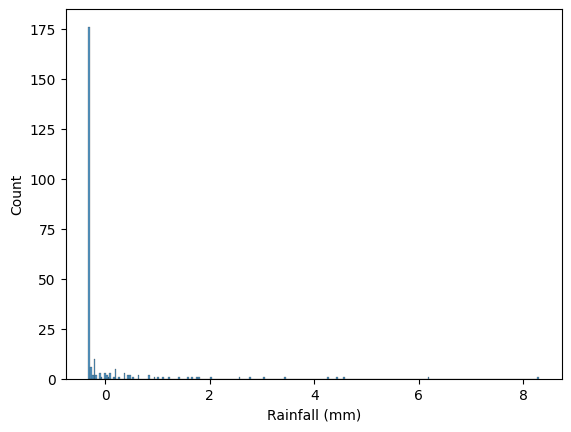

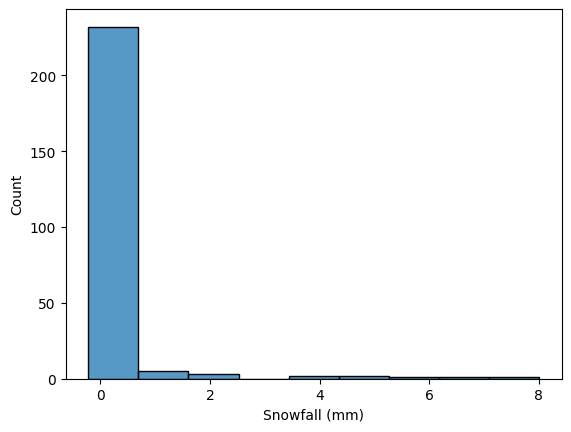

In [35]:
for col in cols:
	sns.histplot(X_train[col])
	plt.show()

In [42]:
def pdp(model):
    model.fit(X_train, y_train)
    # List of all feature names
    features = list(X_train.columns)
    # Generate all unique pairs
    feature_pairs = list(itertools.combinations(features, 2))
    # Store results
    interaction_scores = []
    # Loop over each pair and compute the 2D partial dependence surface
    for pair in feature_pairs:
        try:
            pd_result = partial_dependence(model, X_train, list(pair))
            values = pd_result['average'][0]  # shape: (n_vals_1, n_vals_2)
            # Use std deviation or range as a simple interaction strength proxy
            interaction_strength = np.std(values)  # or np.ptp(values) for range
            interaction_scores.append({
                'feature_1': pair[0],
                'feature_2': pair[1],
                'interaction_strength': interaction_strength
            })
            
        except Exception as e:
            print(f"Skipping {pair}: {e}")

    # Convert to DataFrame and sort
    interaction_df = pd.DataFrame(interaction_scores)
    interaction_df = interaction_df.sort_values(by='interaction_strength', ascending=False)
    clear_output(True)
    return interaction_df

In [43]:
reg_results = pdp(reg)

In [44]:
display(reg_results.head(20))

feature_1                feature_2  interaction_strength
3            Temperature(C)            Rainfall (mm)           4593.865402
2            Temperature(C)  Solar Radiation (MJ/m2)           4403.604814
27  Solar Radiation (MJ/m2)            Rainfall (mm)           4400.112140
8            Temperature(C)                   Winter           4124.554145
38            Rainfall (mm)                   Winter           4120.824964
32  Solar Radiation (MJ/m2)                   Winter           3907.599571
7            Temperature(C)                   Autumn           3801.925220
37            Rainfall (mm)                   Autumn           3797.879259
31  Solar Radiation (MJ/m2)                   Autumn           3565.392389
9            Temperature(C)                  Weekend           3459.551035
39            Rainfall (mm)                  Weekend           3455.104174
6            Temperature(C)                   Summer           3373.690527
36            Rainfall (mm)                   Summer           3369.130341
4            Temperature(C)            Snowfall (mm)           3334.385237
34            Rainfall (mm)            Snowfall (mm)           3329.771223
1            Temperature(C)         Wind speed (m/s)           3303.261428
20         Wind speed (m/s)            Rainfall (mm)           3298.603879
5            Temperature(C)                   Spring           3267.993290
35            Rainfall (mm)                   Spring           3263.285405
0            Temperature(C)              Humidity(%)           3252.070864

In [ ]:
hub_results = pdp(HuberRegressor(alpha=1e-3, epsilon=1.35, max_iter=1000))

In [ ]:
display(hub_results.head(20))

feature_1                feature_2  interaction_strength
3            Temperature(C)  Solar Radiation (MJ/m2)           5122.107064
4            Temperature(C)            Rainfall (mm)           5105.291529
8            Temperature(C)                   Autumn           4582.402725
9            Temperature(C)                   Winter           4533.761381
10           Temperature(C)                  Weekend           4319.921915
5            Temperature(C)            Snowfall (mm)           4217.683852
1            Temperature(C)         Wind speed (m/s)           4207.737286
38  Solar Radiation (MJ/m2)            Rainfall (mm)           4190.697591
6            Temperature(C)                   Spring           4183.427521
7            Temperature(C)                   Summer           4174.807447
0            Temperature(C)              Humidity(%)           4171.452660
2            Temperature(C)         Visibility (10m)           4170.636801
42  Solar Radiation (MJ/m2)                   Autumn           3535.019014
48            Rainfall (mm)                   Autumn           3510.609670
43  Solar Radiation (MJ/m2)                   Winter           3471.733999
49            Rainfall (mm)                   Winter           3446.876526
44  Solar Radiation (MJ/m2)                  Weekend           3187.423732
50            Rainfall (mm)                  Weekend           3160.330817
39  Solar Radiation (MJ/m2)            Snowfall (mm)           3047.425433
22         Wind speed (m/s)  Solar Radiation (MJ/m2)           3033.644304

In [10]:
def test_model(model):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    mse_test = mean_squared_error(y_test, test_pred)
    rmse = np.sqrt(mse_test)

    #clear_output(True)
    print(f"Test Accuracy: {r2_test * 100:.2f}%")
    print(f"Train Accuracy: {r2_train * 100:.2f}%")
    print(f"Accuracy Difference: {(r2_test - r2_train) * 100:.2f}%")
    print(f"Test Mean Squared Error: {mse_test:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Alternatively, it's off by an average of {round(rmse)} bikes")

    # keeping our visualizations in the transformed space
    fig, ax = plt.subplots(1, 3, figsize=(20,7))
    plt.suptitle('')
    ax[0].set_title('Predicted vs Actual for Test Set')
    ax[0].scatter(y_test, test_pred, color='blue', label='Predicted vs Actual')
    ax[0].plot(y_test, y_test, color='red', label='Ideal')
    ax[0].legend()
    ax[0].set_xlabel('Actual')
    ax[0].set_ylabel('Predicted')

    ax[1].set_title('Predicted vs Actual for Train Set')
    ax[1].scatter(y_train, train_pred, color='green', label='Predicted vs Actual')
    ax[1].plot(y_train, y_train, color='red', label='Ideal')
    ax[1].legend()
    ax[1].set_xlabel('Actual')
    ax[1].set_ylabel('Predicted')

    residuals = y_test.reshape(-1,1) - test_pred.reshape(-1,1)
    ax[2].set_title('Residual Plot for Test Set')
    ax[2].scatter(test_pred, residuals, color='blue')
    ax[2].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[2].legend()
    ax[2].set_xlabel("Fitted")
    ax[2].set_ylabel("Residuals")

    plt.show()

Test Accuracy: 86.12%
Train Accuracy: 90.46%
Accuracy Difference: -4.34%
Test Mean Squared Error: 13321860.07
Root Mean Squared Error: 3649.91
Alternatively, it's off by an average of 3650 bikes


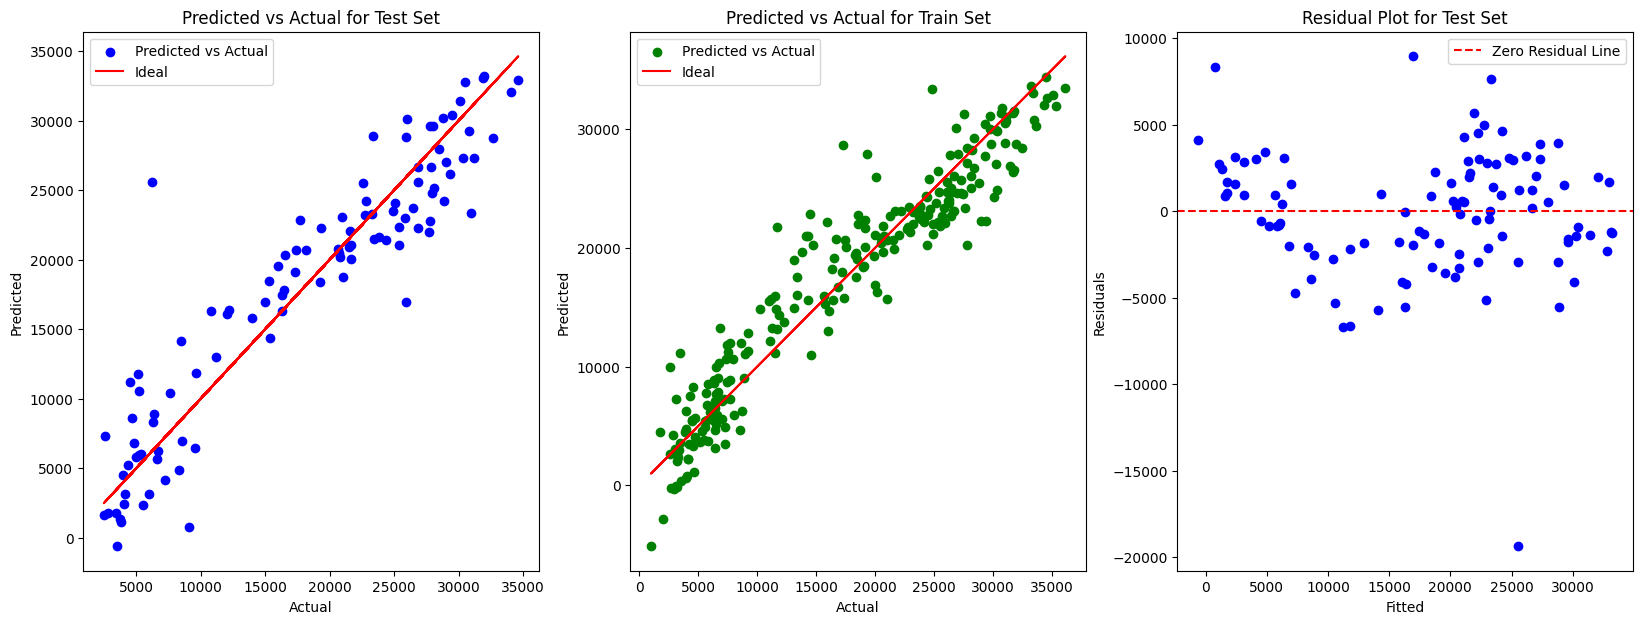

In [92]:
test_model(reg)

Test Accuracy: 90.83%
Train Accuracy: 95.51%
Accuracy Difference: -4.68%
Test Mean Squared Error: 8797425.67
Root Mean Squared Error: 2966.05
Alternatively, it's off by an average of 2966 bikes


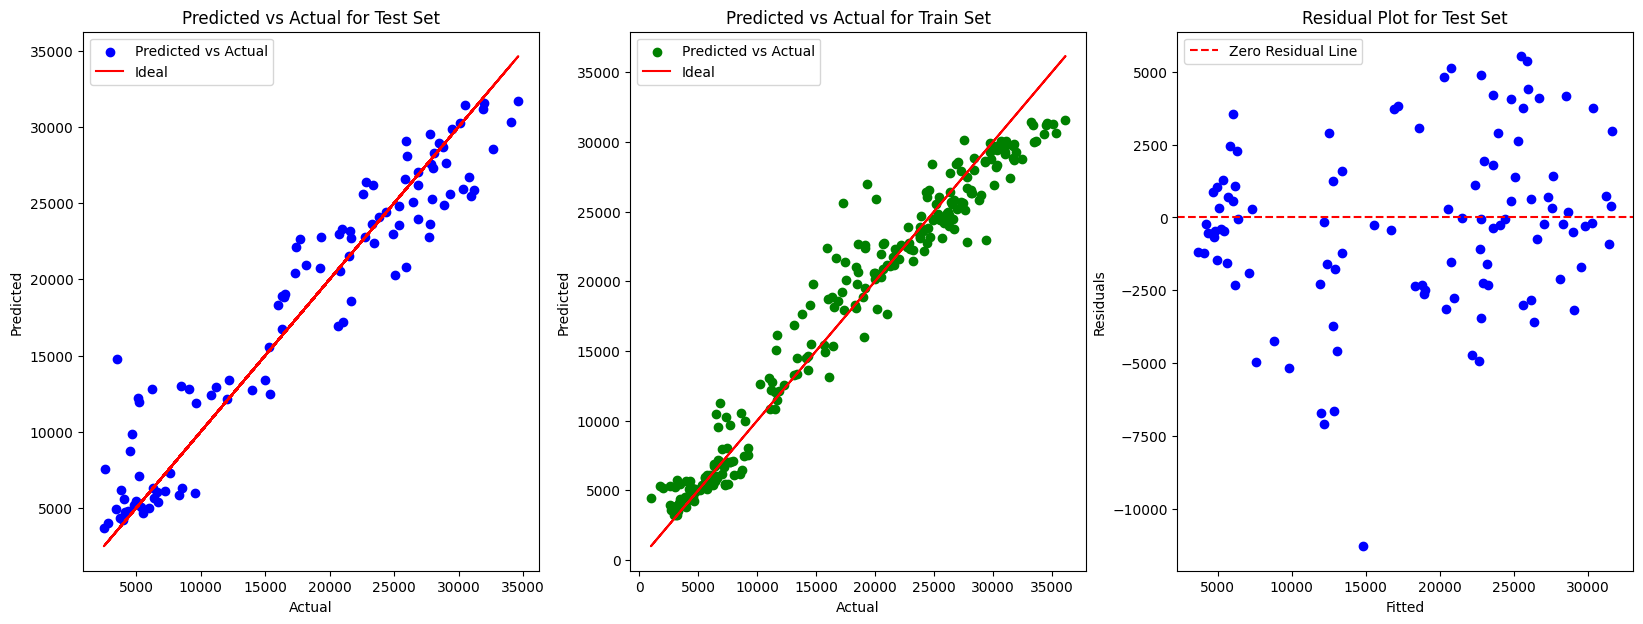

In [89]:
test_model(tree)

                   Feature  Importance
9                   Winter    0.495388
0           Temperature(C)    0.219230
3   Solar Radiation(MJ/m2)    0.157943
4             Rainfall(mm)    0.031226
6                   Spring    0.030555
1              Humidity(%)    0.017307
10                 Weekend    0.015095
12             Summer*Temp    0.013213
8                   Autumn    0.010771
7                   Summer    0.003719
2          Wind Speed(m/s)    0.003561
11             Winter*Temp    0.001540
5             Snowfall(mm)    0.000454


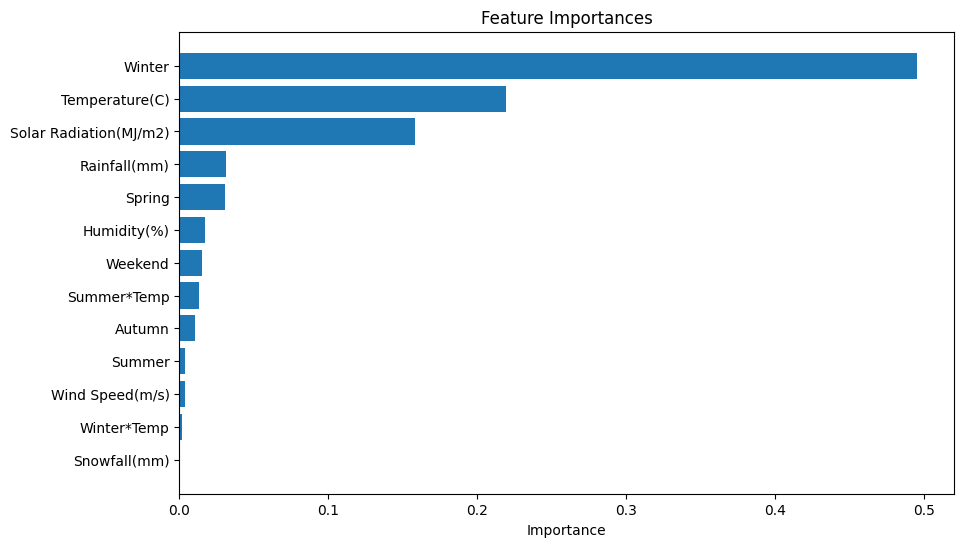

In [84]:
importances = tree.feature_importances_
feature_names = X.columns

# Create a DataFrame for easier viewing
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print top features
print(importance_df)

# Optional: Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [91]:
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'feature_{i}' for i in range(X_train.shape[1])]

# Get coefficients
coefs = reg.coef_

# Create DataFrame of importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefs
})

# Sort by absolute importance
importance_df['Abs_Importance'] = np.abs(importance_df['Importance'])
importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)

print(importance_df[['Feature', 'Importance']])

                   Feature    Importance
7                   Summer  32523.829777
9                   Winter -13699.135580
6                   Spring -11447.333371
8                   Autumn  -7377.360826
10                 Weekend  -2707.279868
3   Solar Radiation(MJ/m2)   2433.174649
11             Summer*Temp  -1677.235855
0           Temperature(C)    592.585567
2          Wind Speed(m/s)   -551.695537
4             Rainfall(mm)   -253.612066
1              Humidity(%)    -68.082855
5             Snowfall(mm)      0.009495


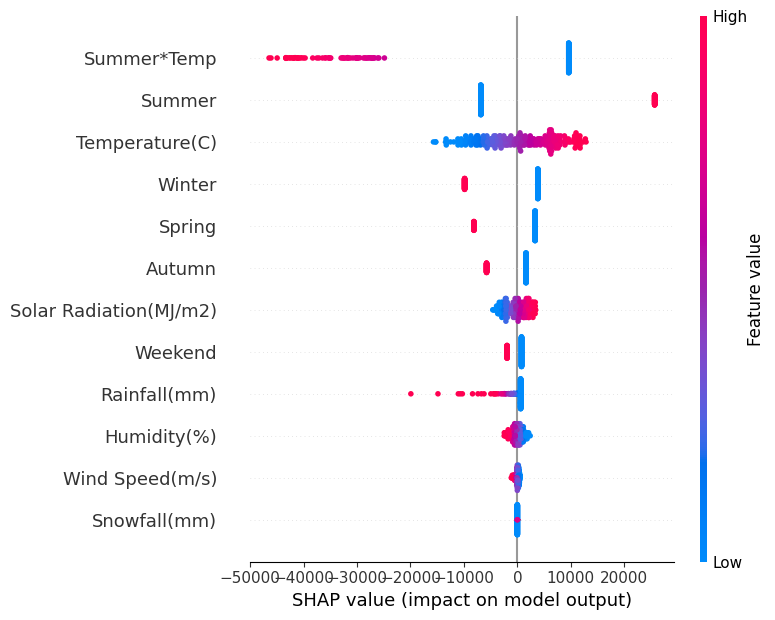

In [90]:
explainer = shap.LinearExplainer(reg, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

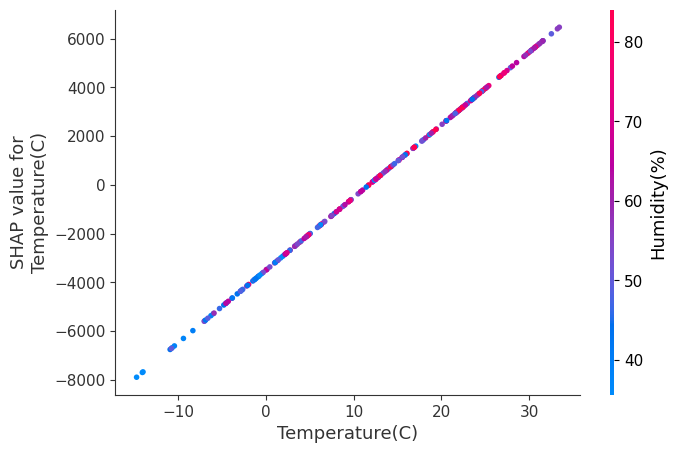

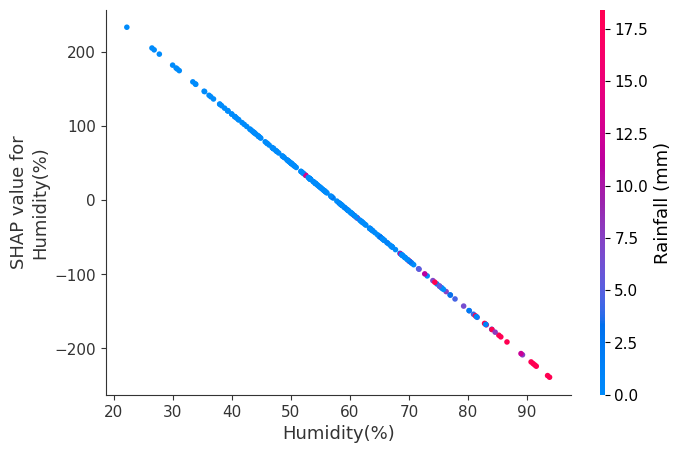

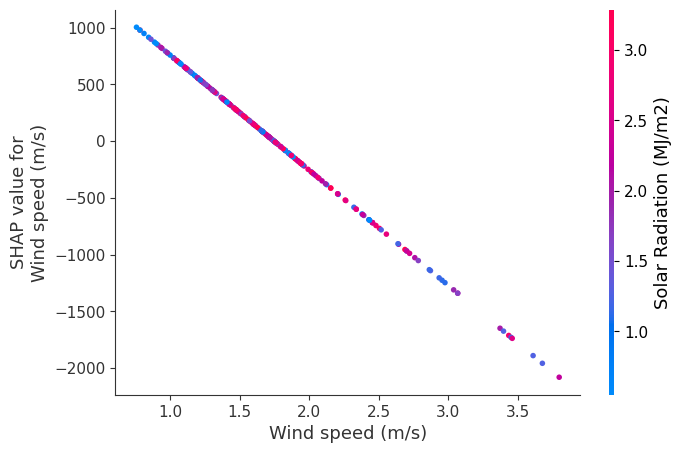

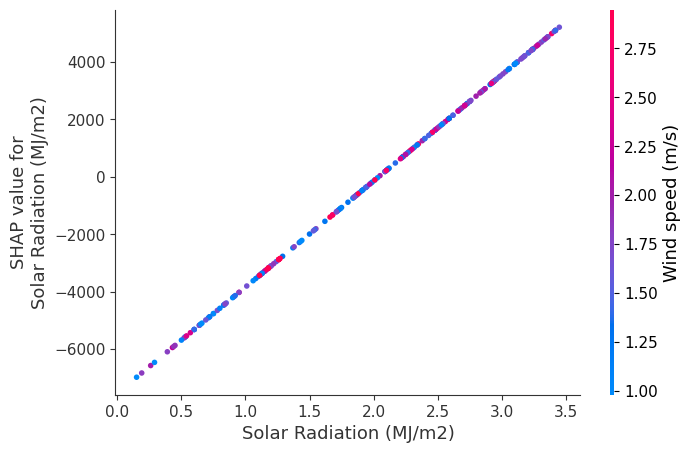

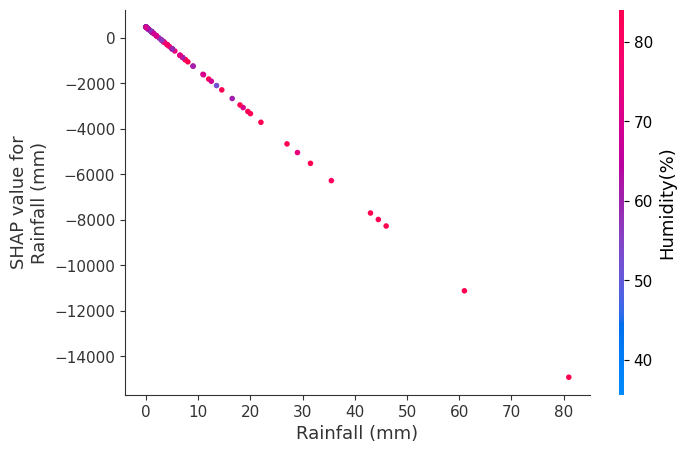

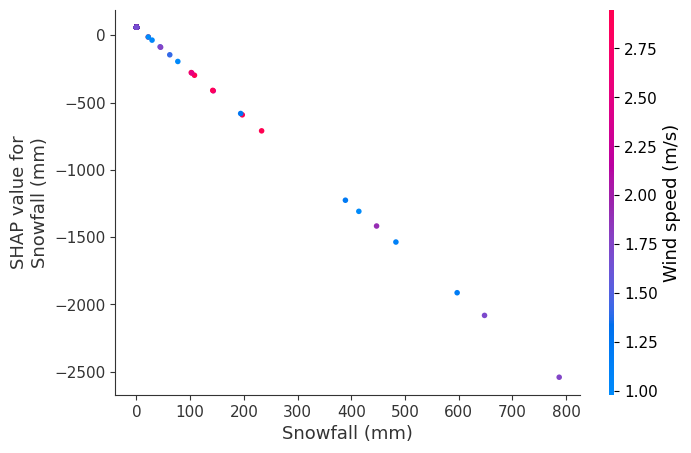

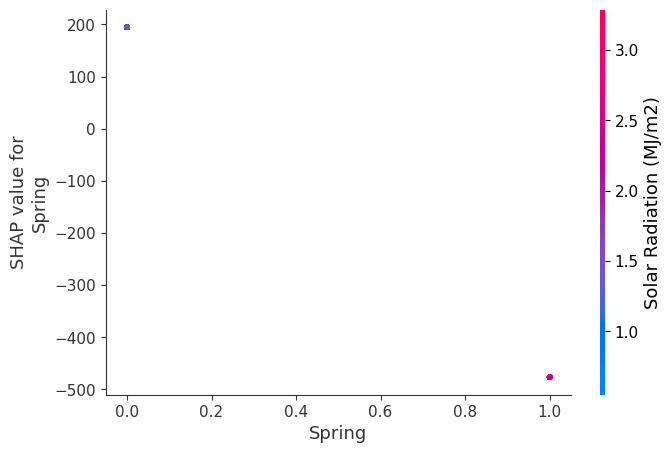

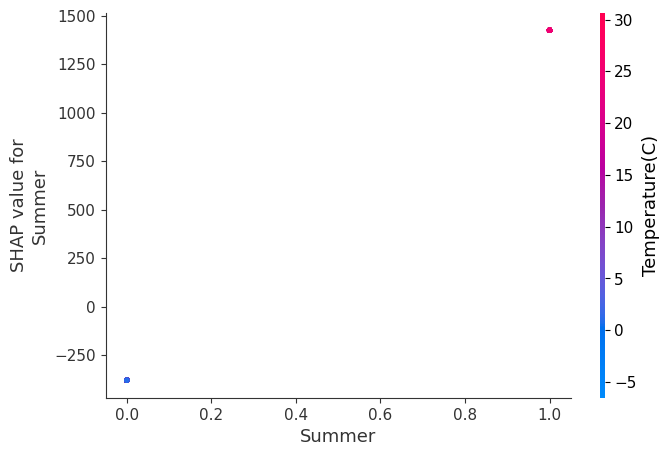

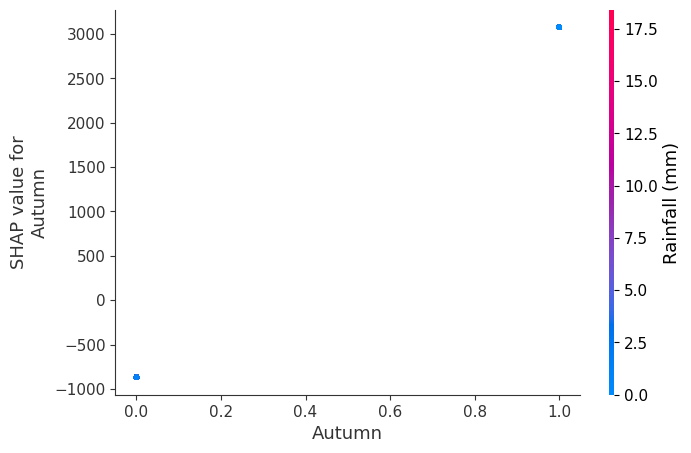

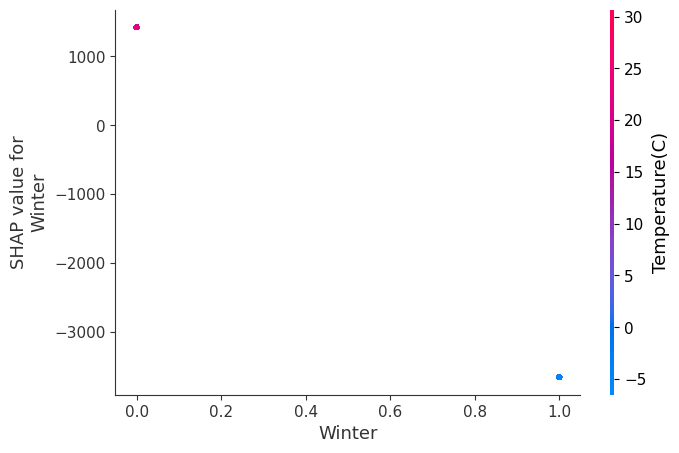

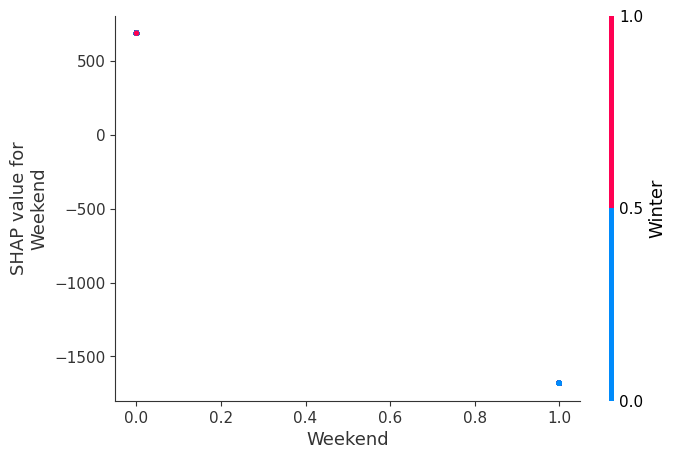

In [48]:
for feature in X_train.columns:
    shap.dependence_plot(feature, shap_values, X_train)

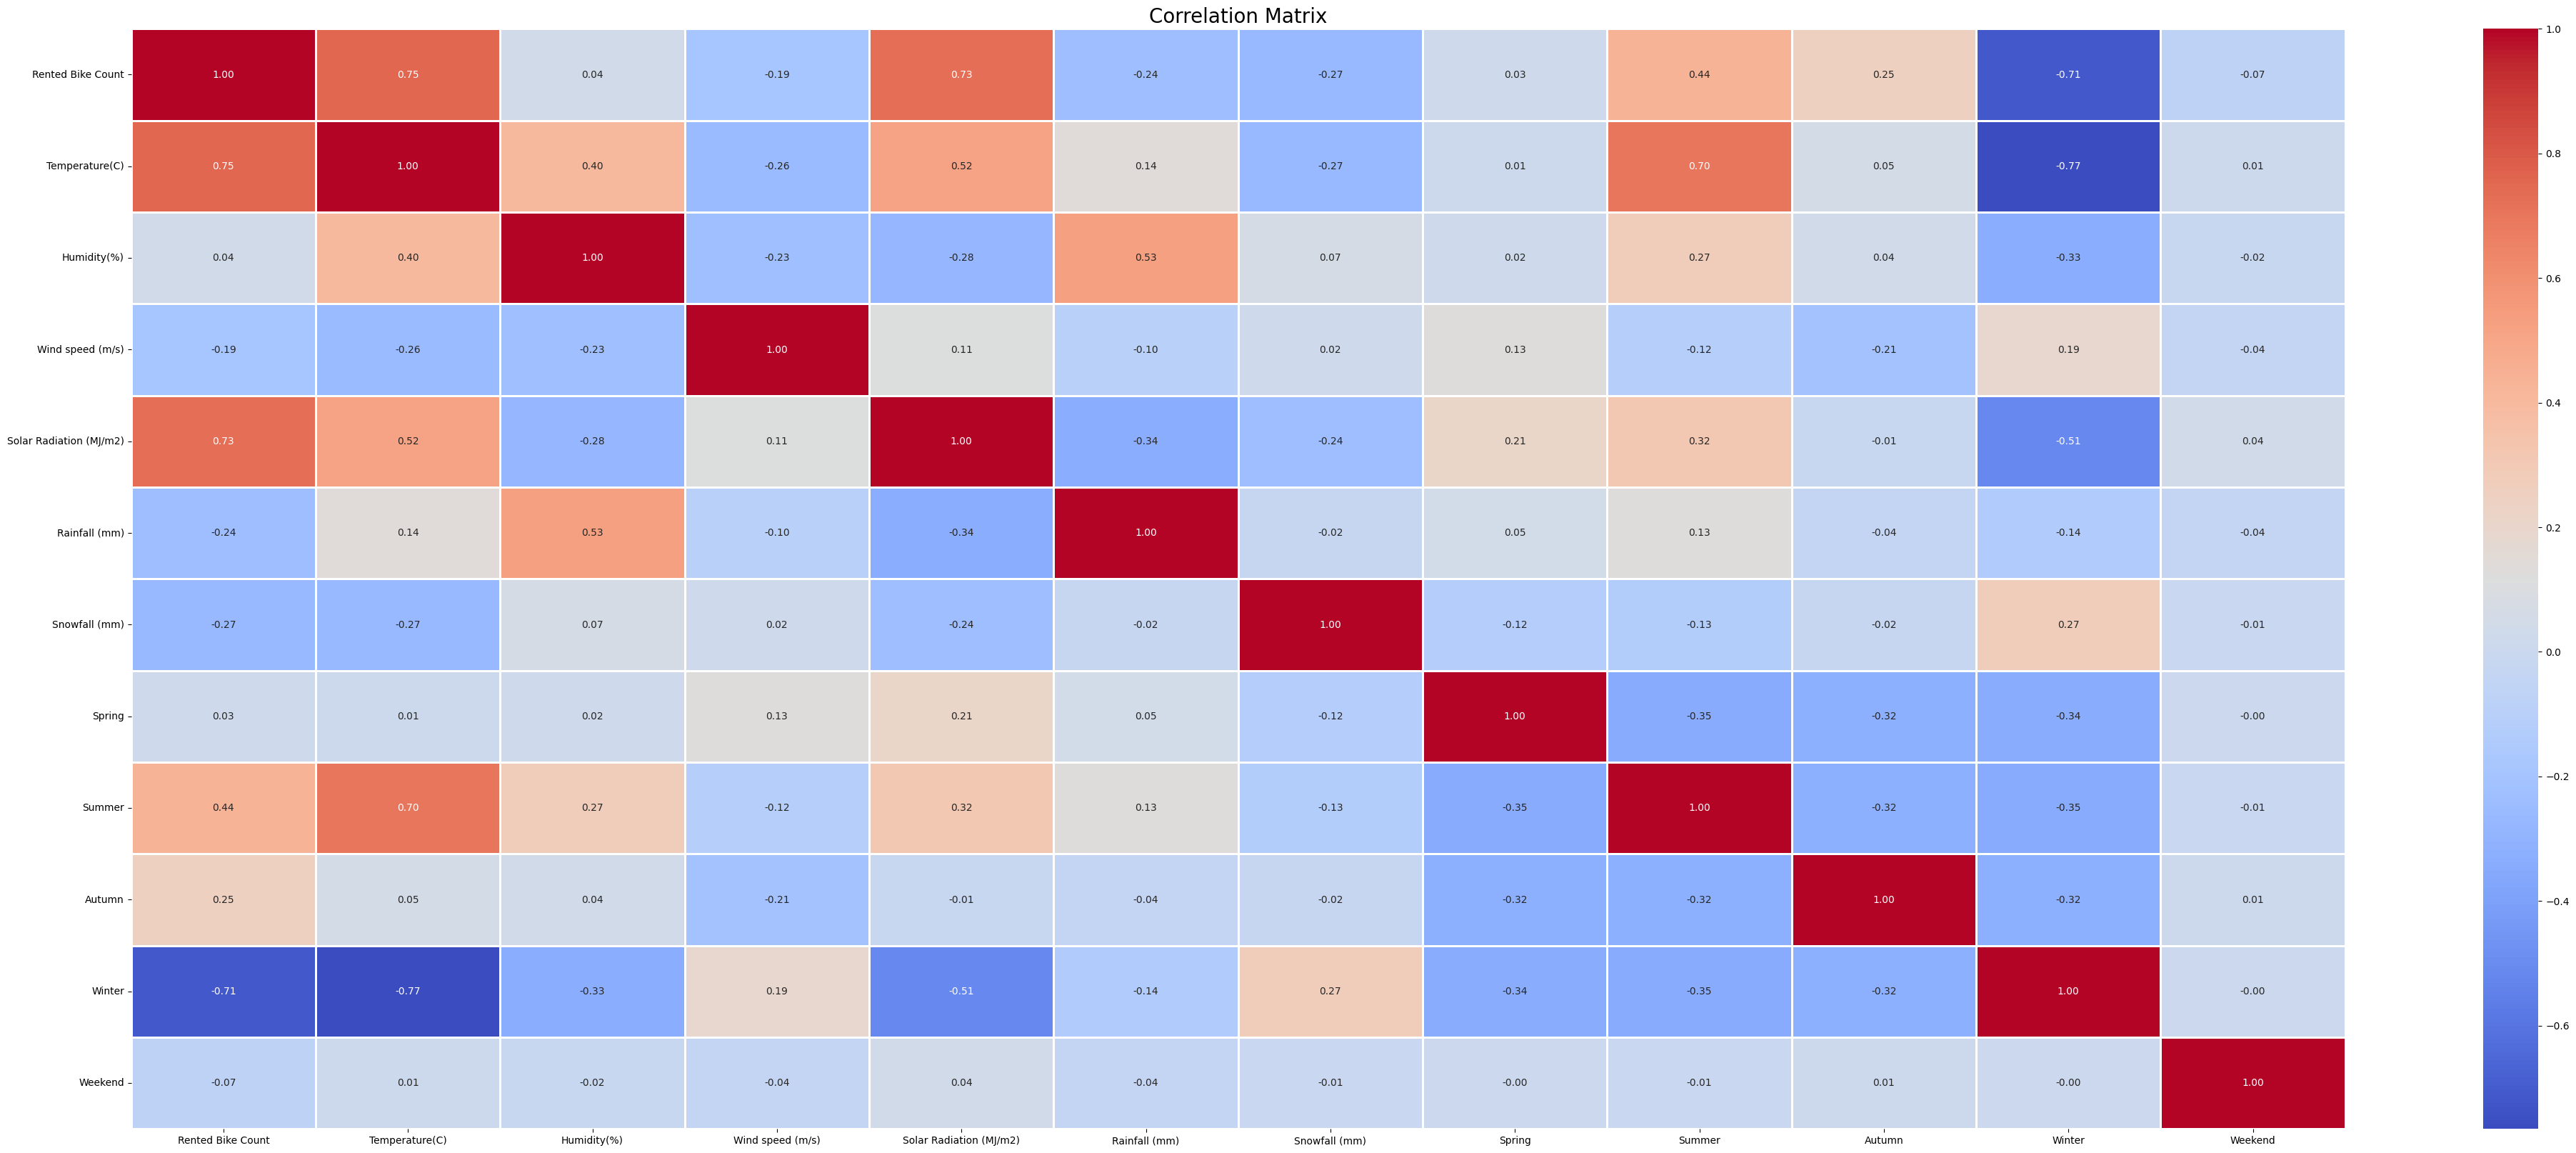

In [50]:
# doing season*temp makes it easier to explain how we captured the interaction
corr_matrix = df.corr()
plt.figure(figsize=(50, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=2)
plt.title("Correlation Matrix", fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

In [63]:
from sklearn.inspection import PartialDependenceDisplay

def plot_top_pdp_2d(model, X_train, n=5):
    """
    Plots 2D PDPs for the top n feature interaction pairs.
    
    Parameters:
        model: fitted scikit-learn model
        X_train: training feature DataFrame
        top_pairs: list of tuples, each with two feature names
        n: number of top interactions to plot
    """
    model.fit(X_train, y_train)  # Fit if not already
    features = list(X_train.columns)
    # Generate all unique pairs
    feature_pairs = list(itertools.combinations(features, 2))
    for i, (f1, f2) in enumerate(feature_pairs):
        print(f"\nPlotting {f1} × {f2}...")
        try:
            fig = plt.figure(figsize=(6, 5))
            display = PartialDependenceDisplay.from_estimator(
                model, X_train, [(f1, f2)], kind='average', ax=plt.gca()
            )
            plt.title(f'PDP: {f1} × {f2}')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not plot {f1} × {f2}: {e}")


Plotting Temperature(C) × Humidity(%)...


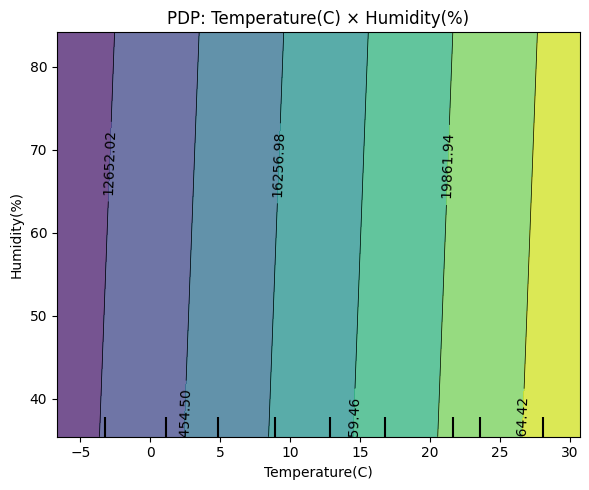


Plotting Temperature(C) × Wind Speed(m/s)...


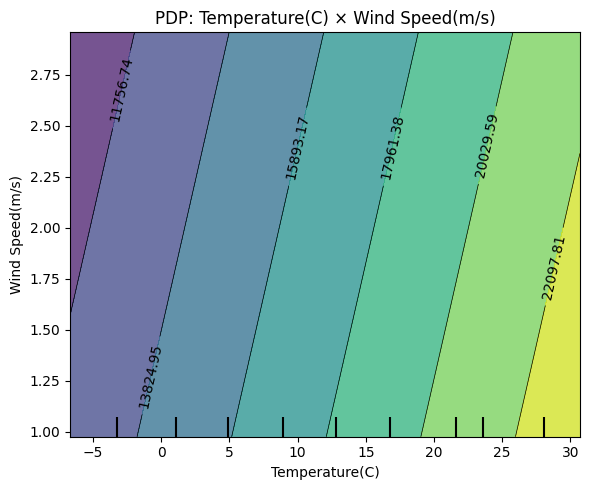


Plotting Temperature(C) × Solar Radiation(MJ/m2)...


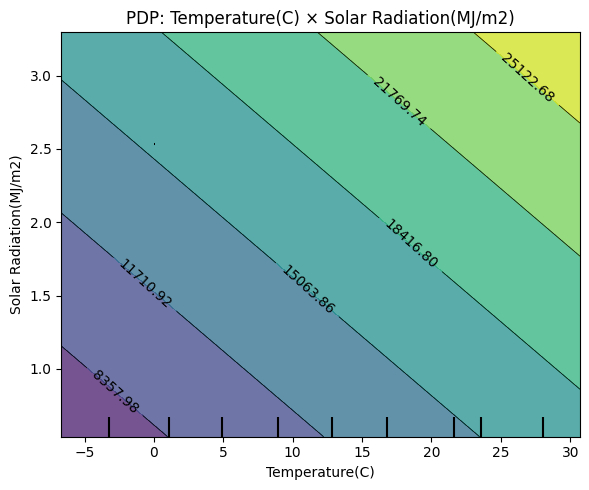


Plotting Temperature(C) × Rainfall(mm)...


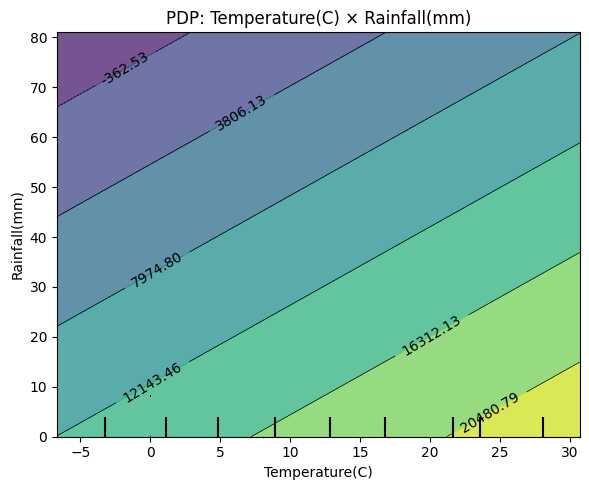


Plotting Temperature(C) × Snowfall(mm)...


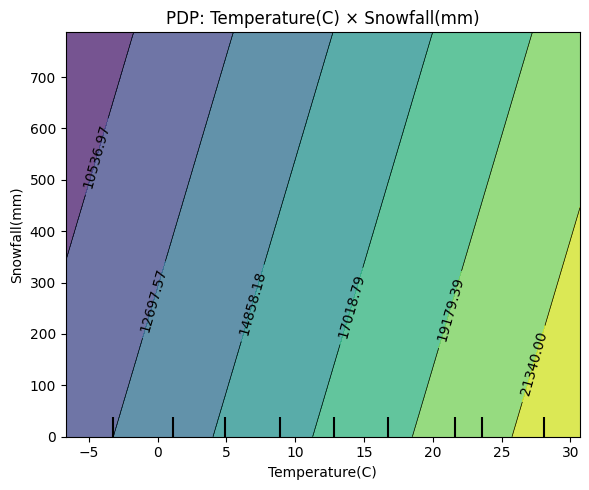


Plotting Temperature(C) × Spring...


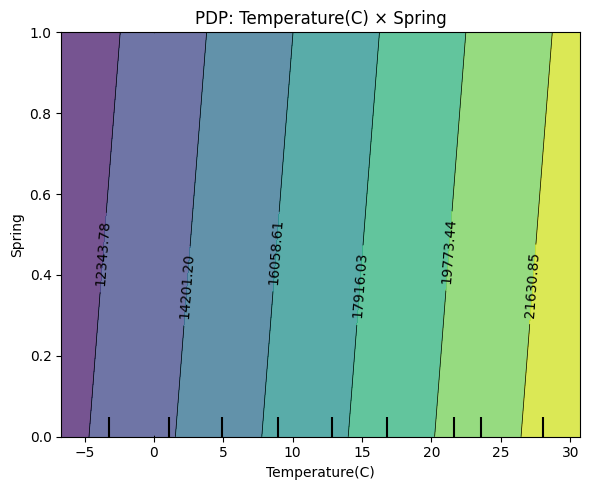


Plotting Temperature(C) × Summer...


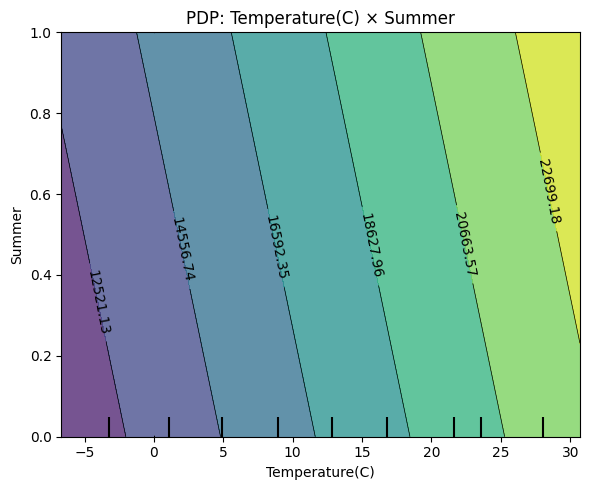


Plotting Temperature(C) × Autumn...


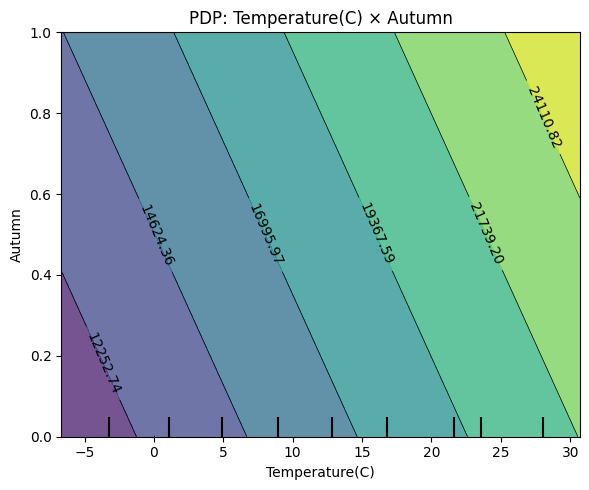


Plotting Temperature(C) × Winter...


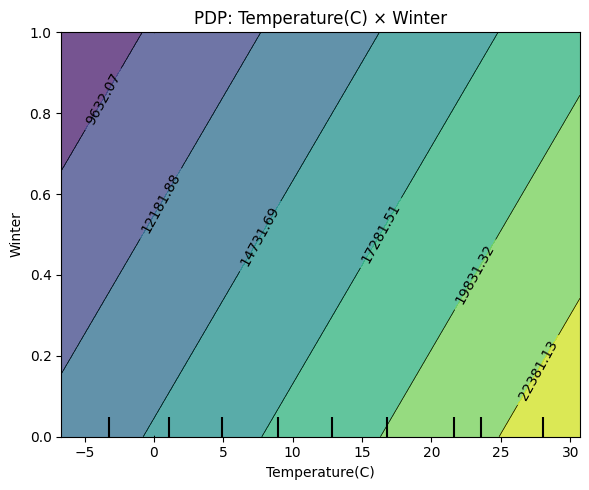


Plotting Temperature(C) × Weekend...


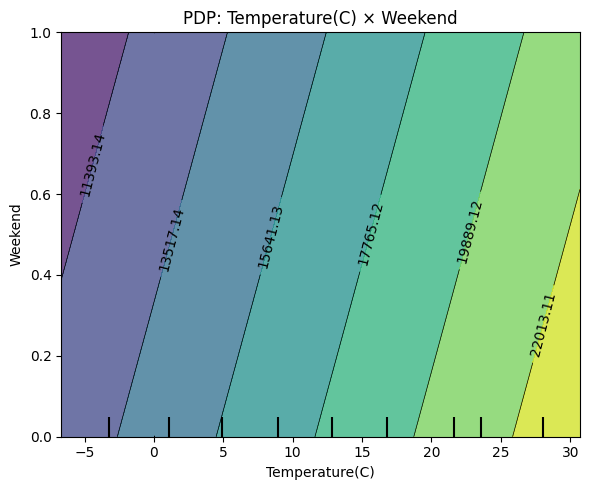


Plotting Humidity(%) × Wind Speed(m/s)...


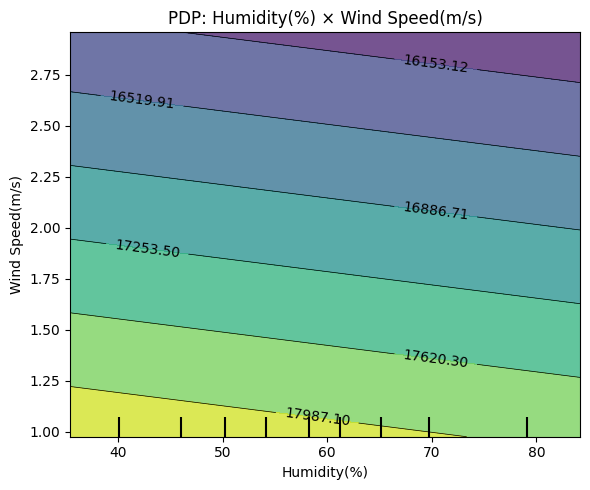


Plotting Humidity(%) × Solar Radiation(MJ/m2)...


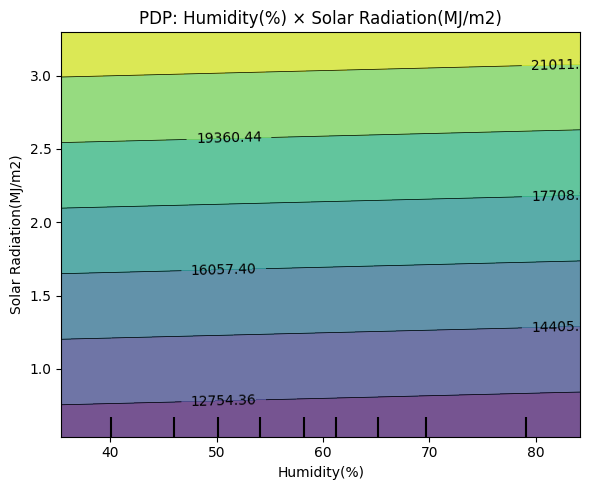


Plotting Humidity(%) × Rainfall(mm)...


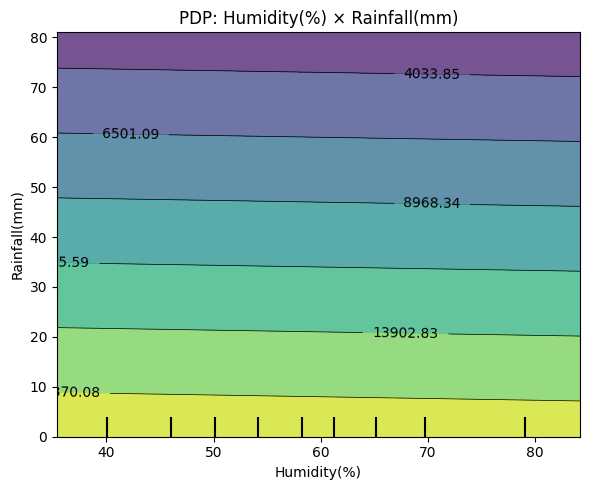


Plotting Humidity(%) × Snowfall(mm)...


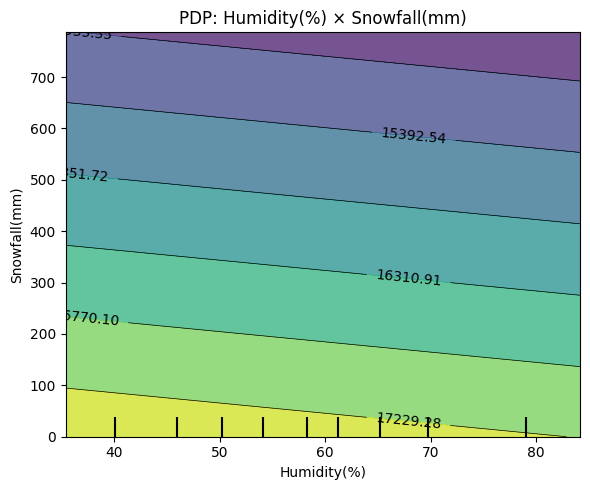


Plotting Humidity(%) × Spring...


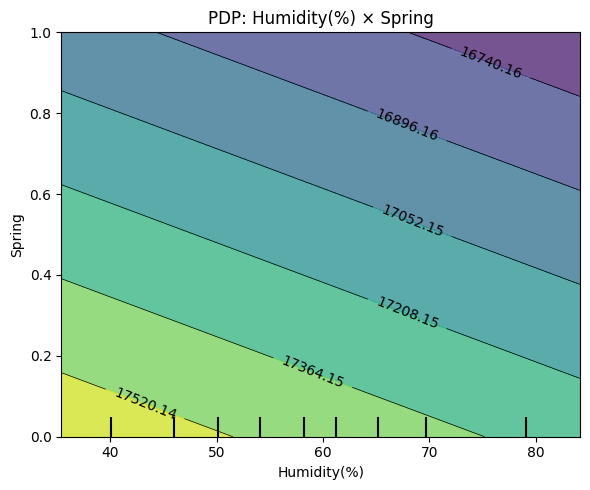


Plotting Humidity(%) × Summer...


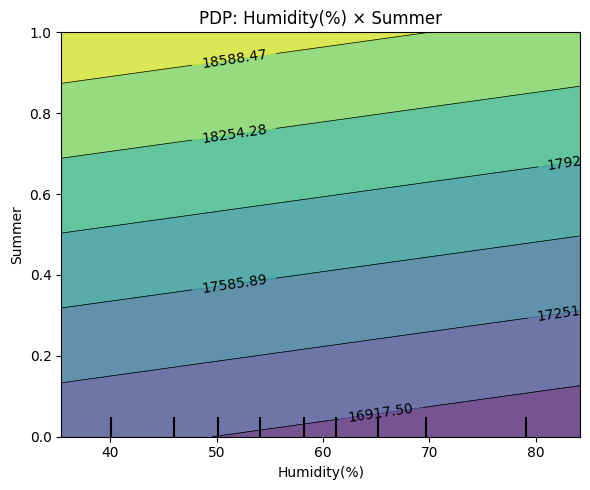


Plotting Humidity(%) × Autumn...


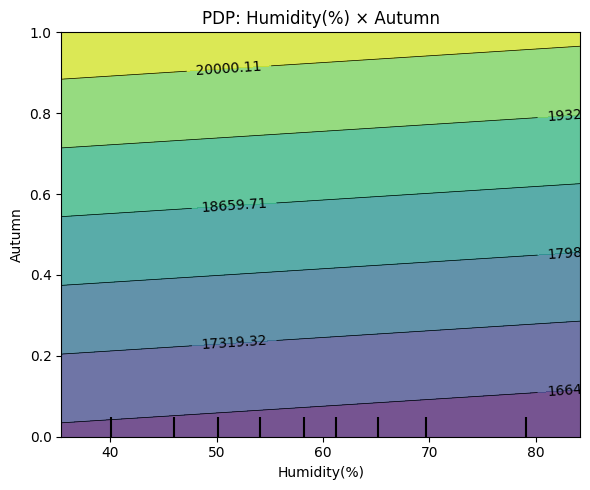


Plotting Humidity(%) × Winter...


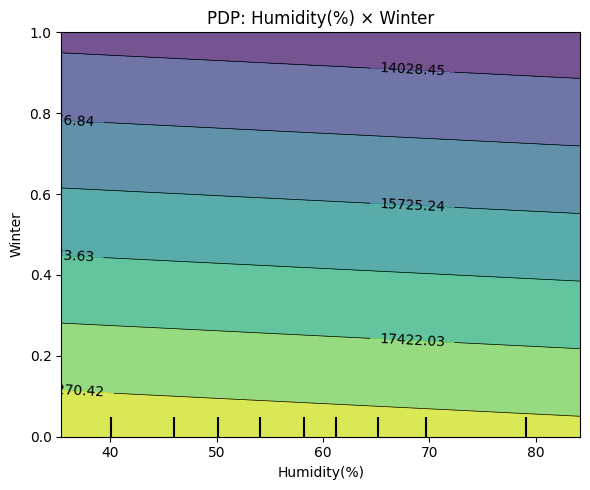


Plotting Humidity(%) × Weekend...


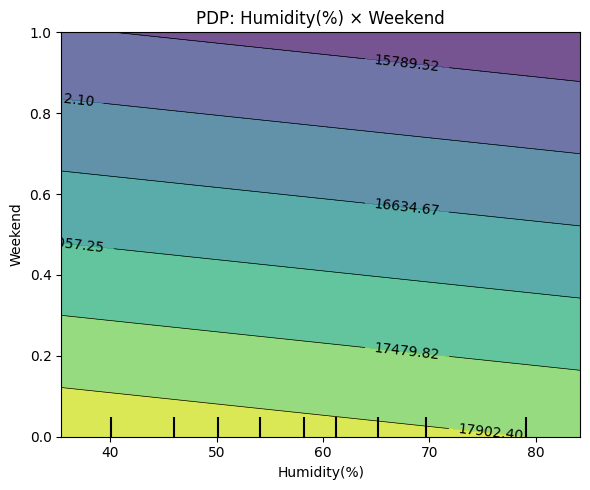


Plotting Wind Speed(m/s) × Solar Radiation(MJ/m2)...


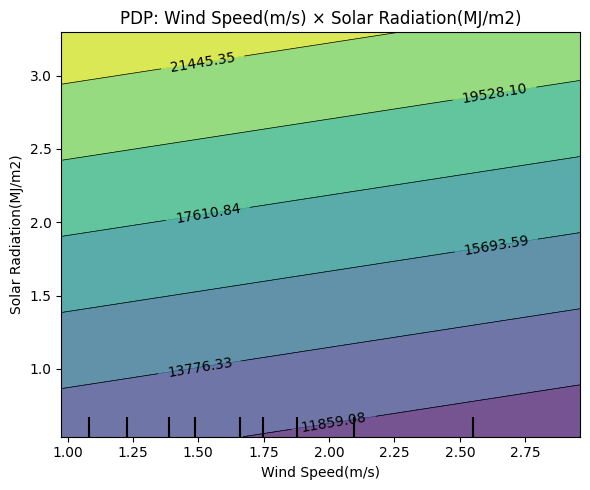


Plotting Wind Speed(m/s) × Rainfall(mm)...


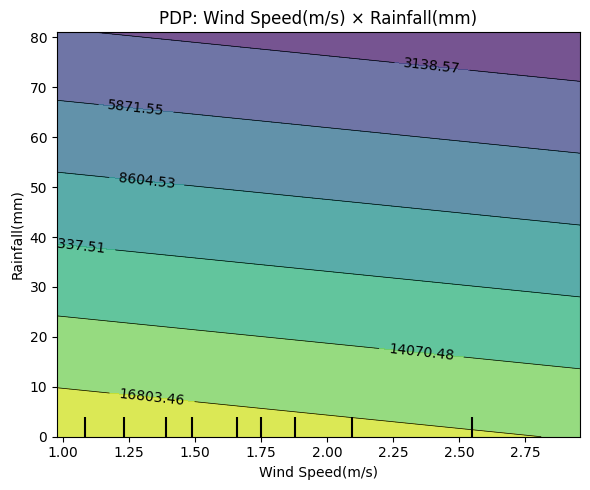


Plotting Wind Speed(m/s) × Snowfall(mm)...


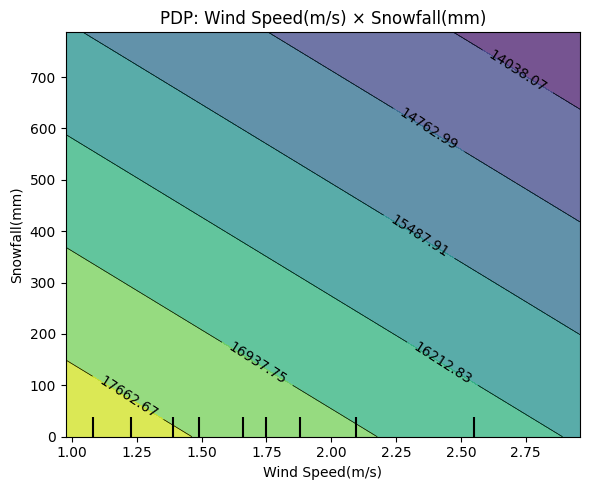


Plotting Wind Speed(m/s) × Spring...


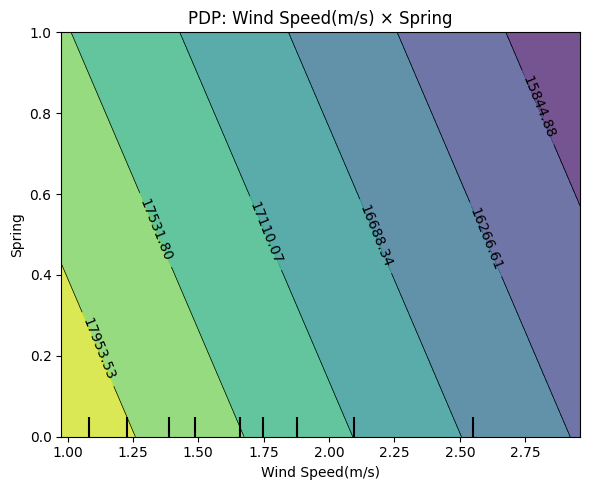


Plotting Wind Speed(m/s) × Summer...


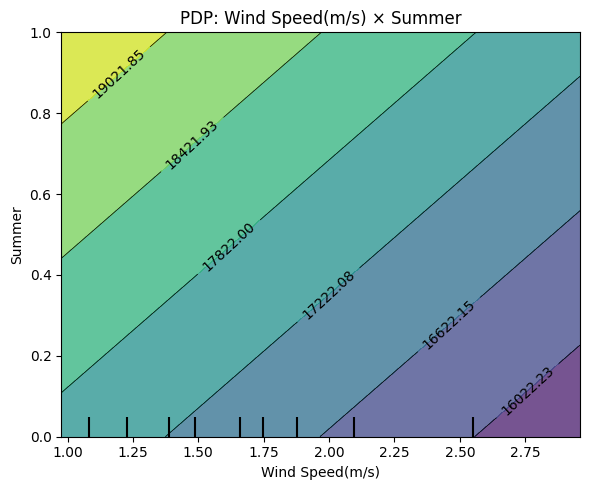


Plotting Wind Speed(m/s) × Autumn...


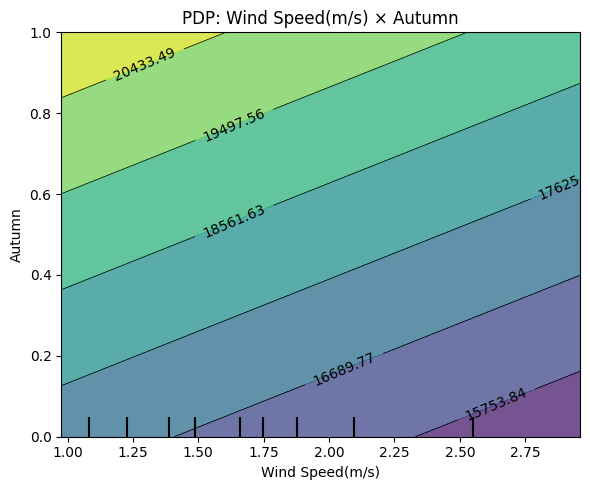


Plotting Wind Speed(m/s) × Winter...


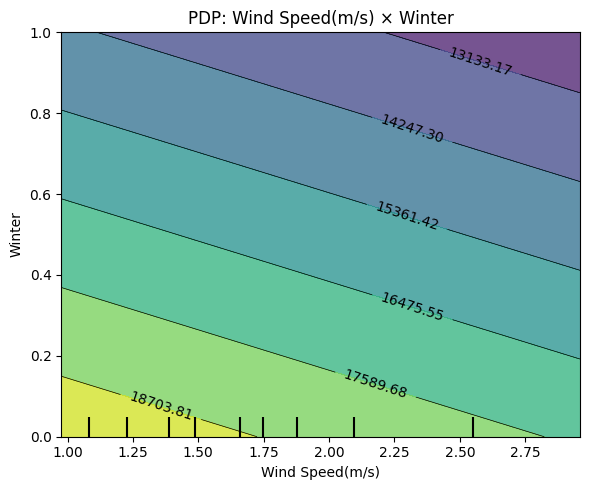


Plotting Wind Speed(m/s) × Weekend...


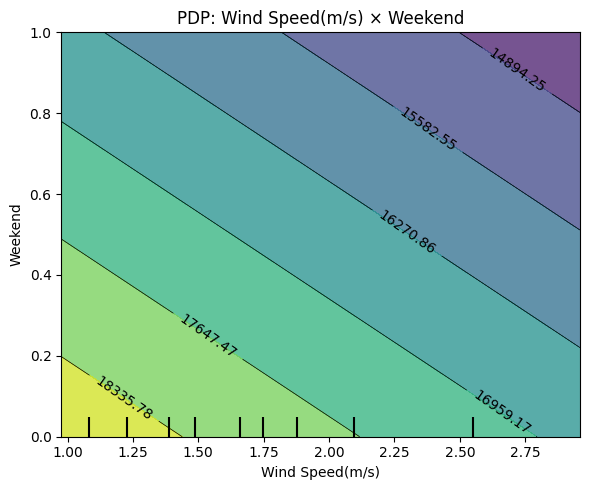


Plotting Solar Radiation(MJ/m2) × Rainfall(mm)...


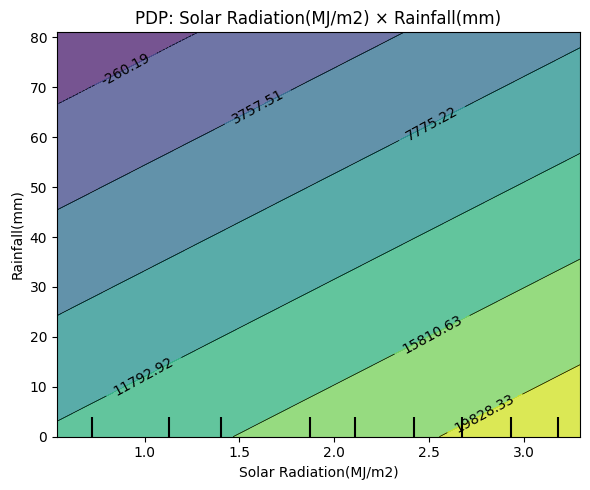


Plotting Solar Radiation(MJ/m2) × Snowfall(mm)...


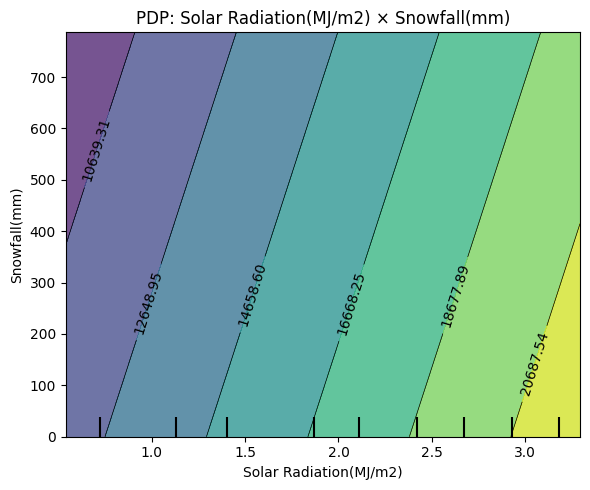


Plotting Solar Radiation(MJ/m2) × Spring...


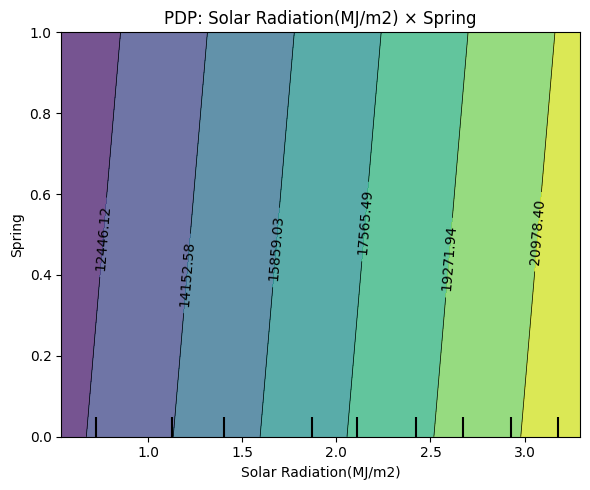


Plotting Solar Radiation(MJ/m2) × Summer...


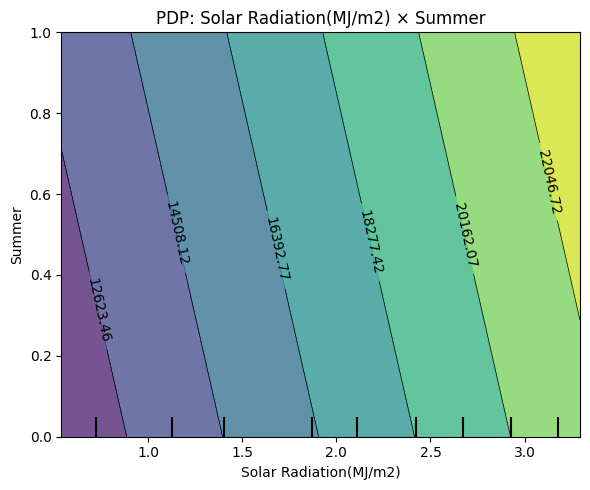


Plotting Solar Radiation(MJ/m2) × Autumn...


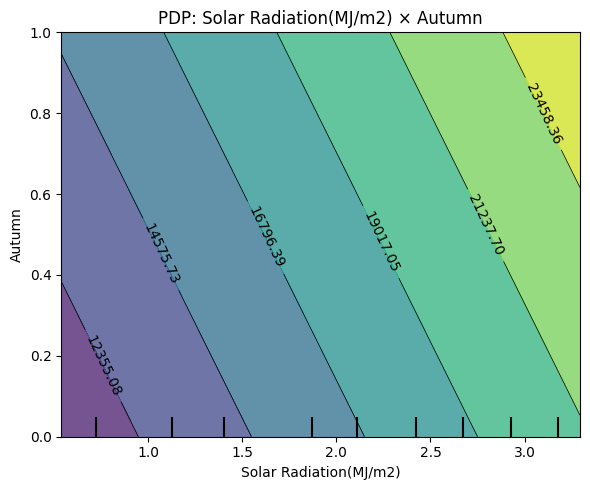


Plotting Solar Radiation(MJ/m2) × Winter...


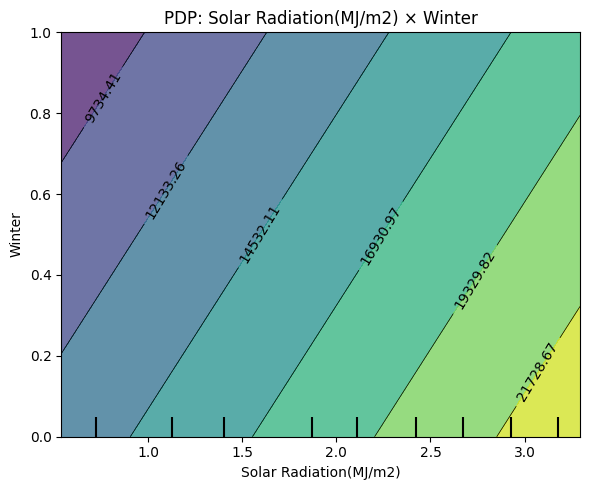


Plotting Solar Radiation(MJ/m2) × Weekend...


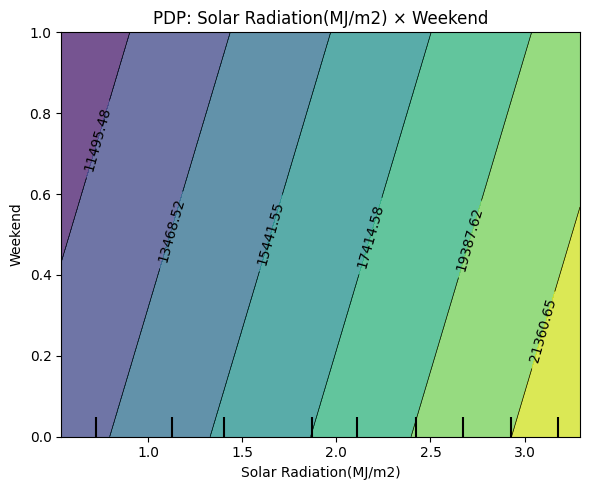


Plotting Rainfall(mm) × Snowfall(mm)...


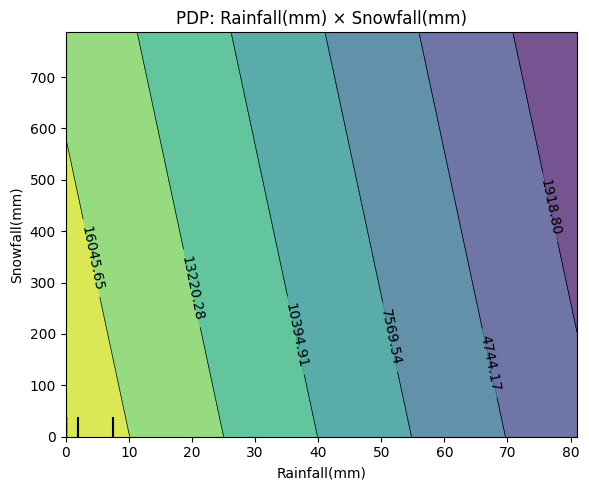


Plotting Rainfall(mm) × Spring...


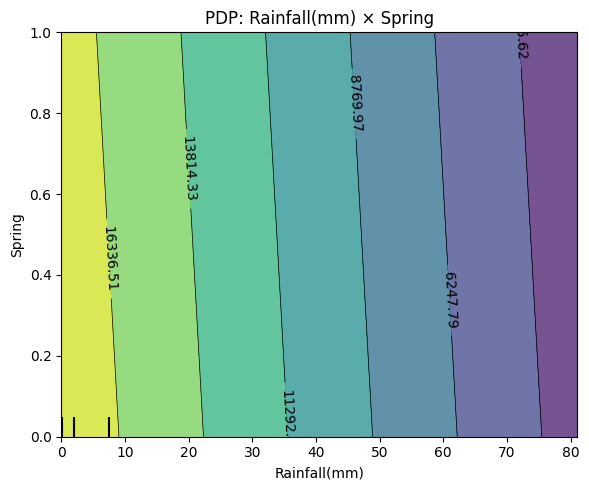


Plotting Rainfall(mm) × Summer...


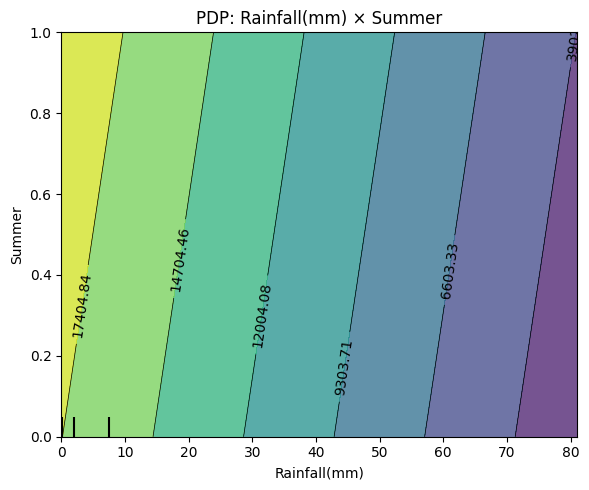


Plotting Rainfall(mm) × Autumn...


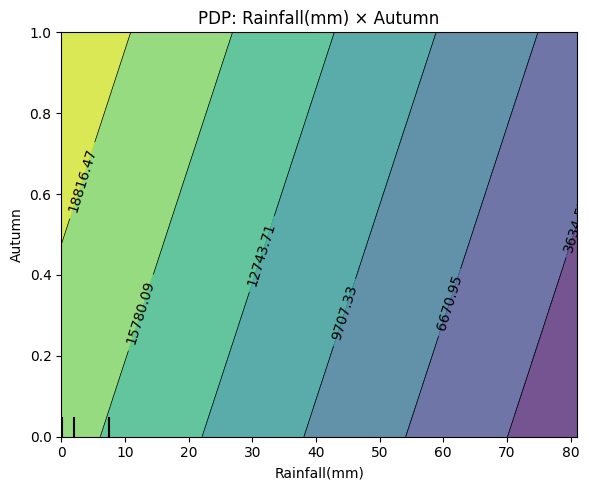


Plotting Rainfall(mm) × Winter...


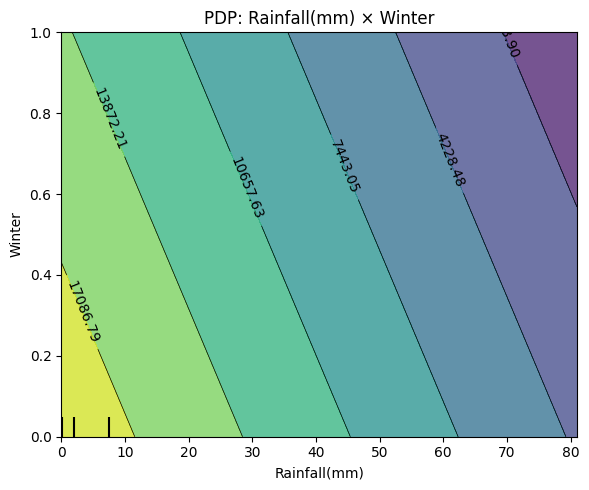


Plotting Rainfall(mm) × Weekend...


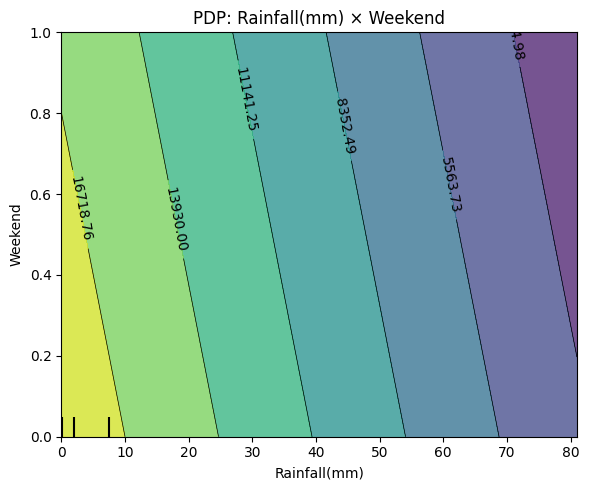


Plotting Snowfall(mm) × Spring...


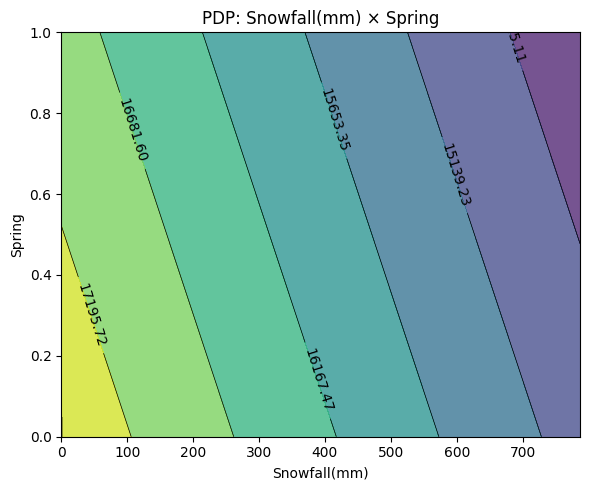


Plotting Snowfall(mm) × Summer...


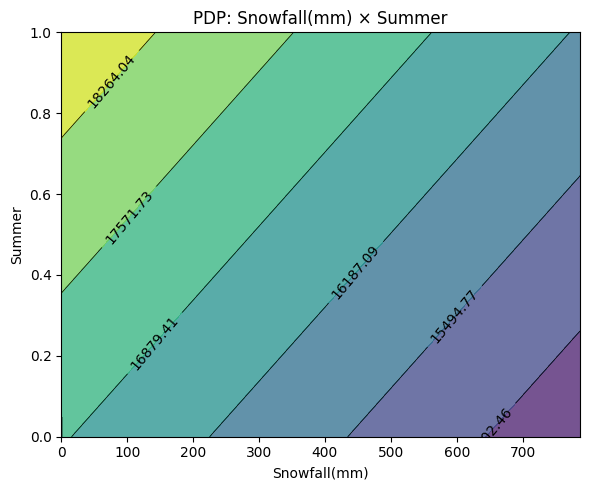


Plotting Snowfall(mm) × Autumn...


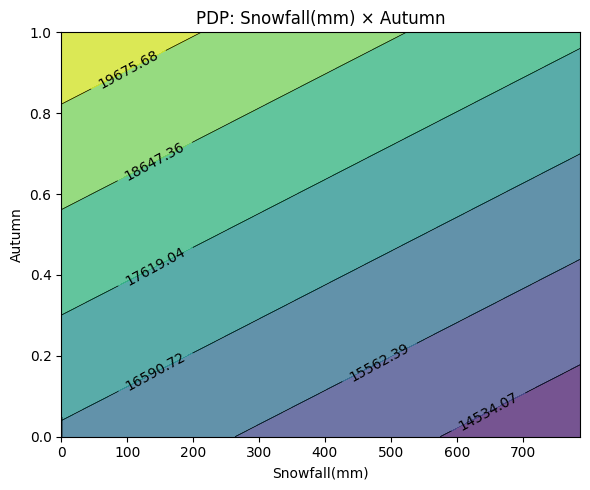


Plotting Snowfall(mm) × Winter...


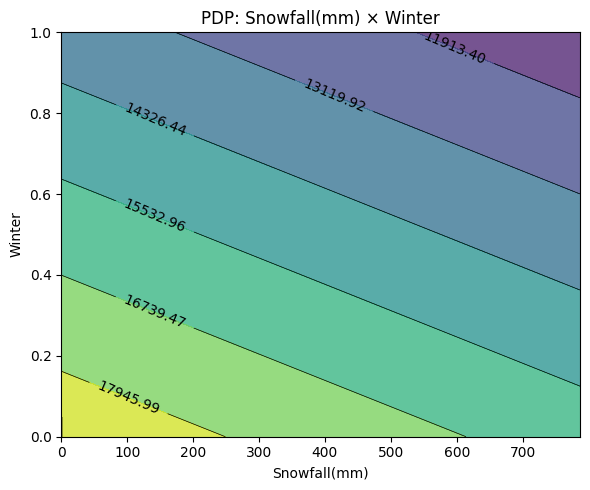


Plotting Snowfall(mm) × Weekend...


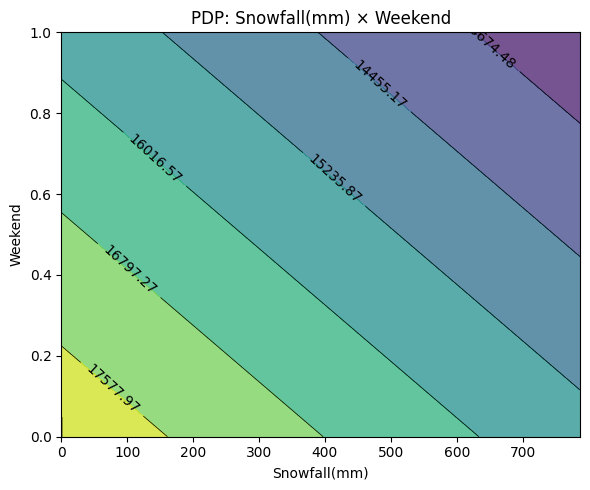


Plotting Spring × Summer...


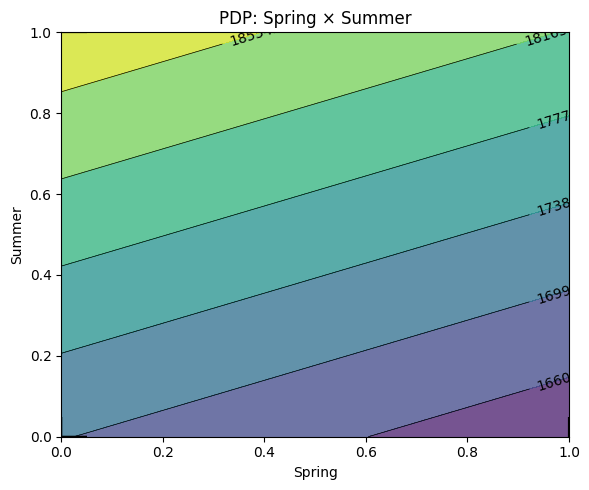


Plotting Spring × Autumn...


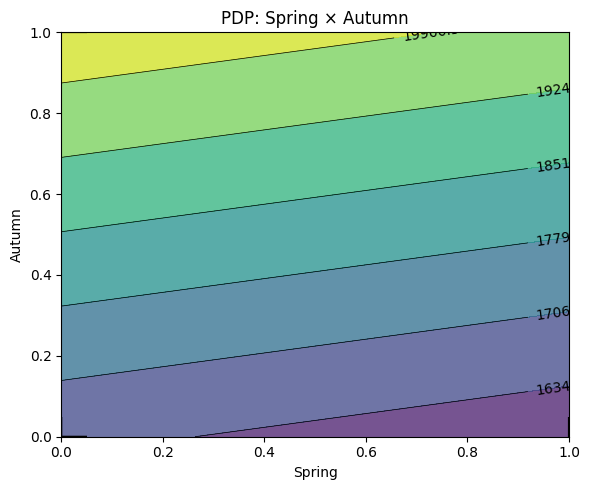


Plotting Spring × Winter...


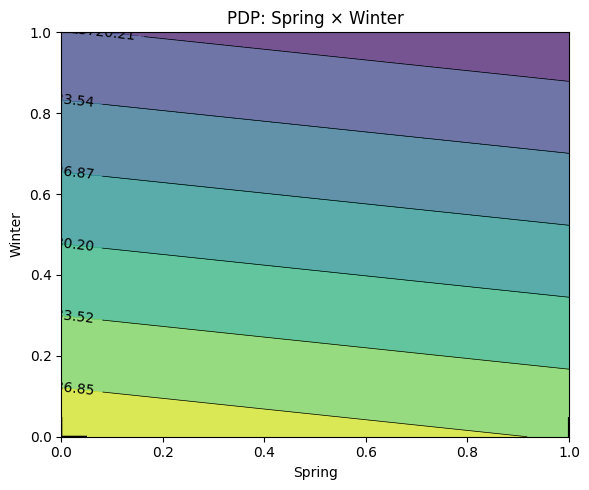


Plotting Spring × Weekend...


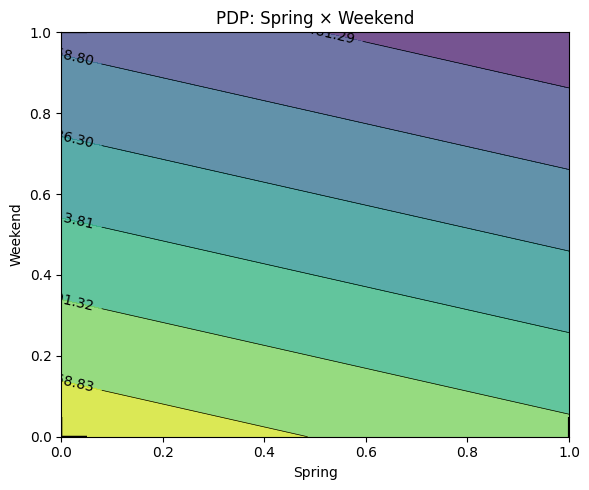


Plotting Summer × Autumn...


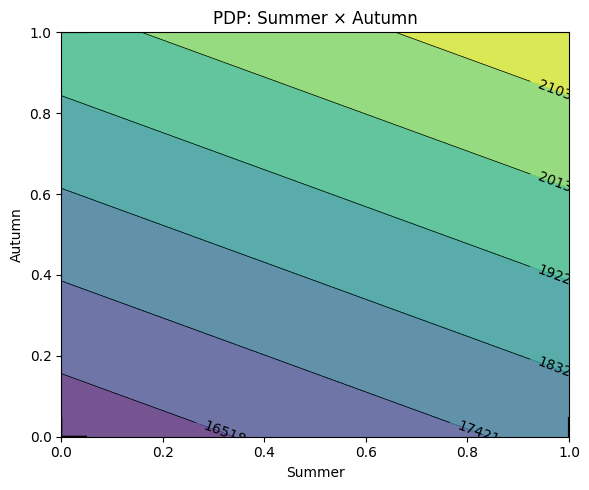


Plotting Summer × Winter...


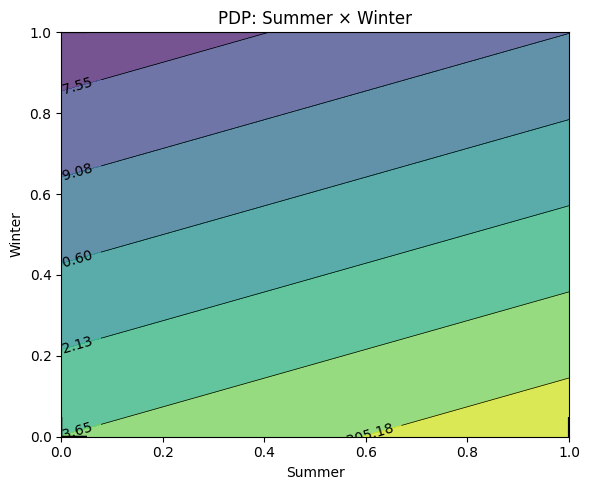


Plotting Summer × Weekend...


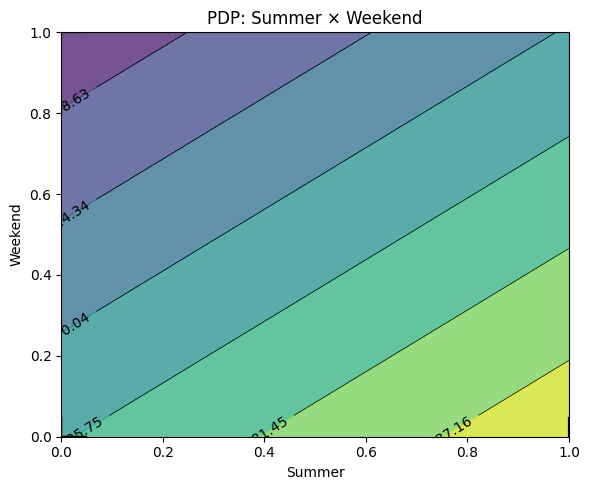


Plotting Autumn × Winter...


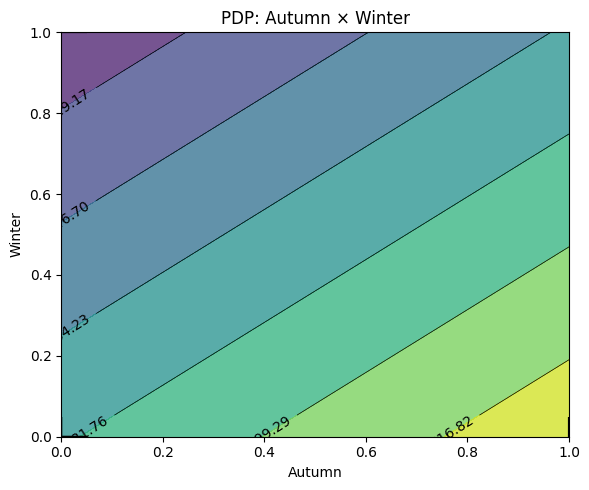


Plotting Autumn × Weekend...


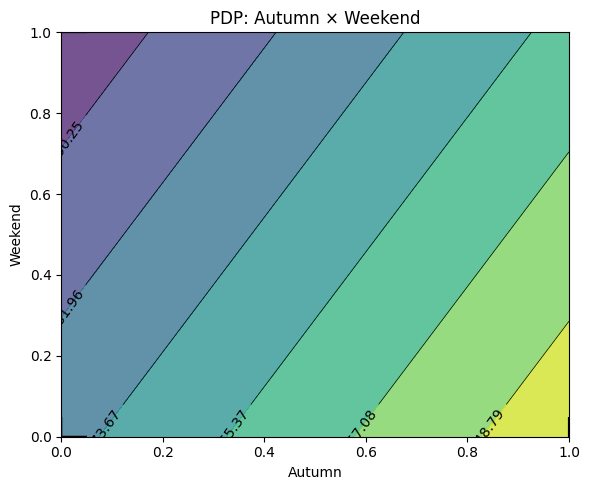


Plotting Winter × Weekend...


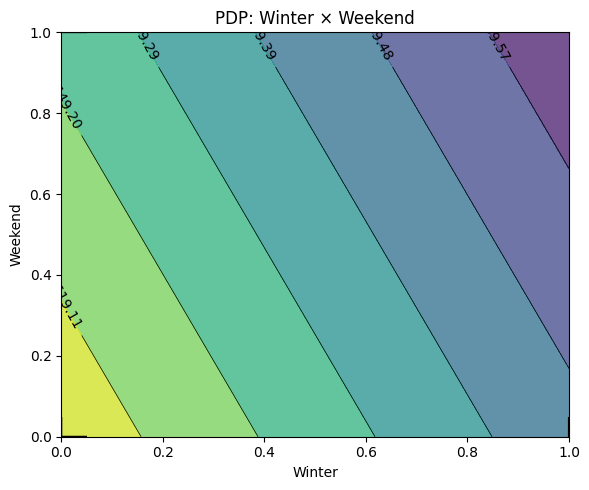

In [64]:
plot_top_pdp_2d(reg, X_train)

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Set include_bias=False to remove intercept term
    ('model', LinearRegression())
])

# Fit model
poly_pipeline.fit(X_train, y_train)

# Evaluate
print("R² score on test set:", poly_pipeline.score(X_test, y_test))

R² score on test set: 0.8411434570933394


In [62]:
features = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(m/s)', 'Solar Radiation(MJ/m2)', 
            'Rainfall(mm)', 'Snowfall(mm)', 'Spring', 'Summer', 'Autumn', 'Winter', 'Weekend']

X = df[features]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interact = poly.fit_transform(X)

# Optional: get feature names for the new interaction terms
feature_names = poly.get_feature_names_out(features)
X_interact_df = pd.DataFrame(X_interact, columns=feature_names)
X_interact_df

Temperature(C)  Humidity(%)  Wind Speed(m/s)  Solar Radiation(MJ/m2)  \
0         -2.454167    45.875000         1.537500                    1.16   
1          1.325000    61.958333         1.712500                    1.12   
2          4.875000    81.541667         1.612500                    0.69   
3         -0.304167    52.500000         3.450000                    1.17   
4         -4.458333    36.416667         1.108333                    0.64   
..              ...          ...              ...                     ...   
348        6.320833    70.500000         1.029167                    1.74   
349        7.066667    68.000000         1.350000                    0.87   
350        5.304167    25.791667         1.695833                    1.86   
351        3.304167    38.000000         1.212500                    0.64   
352        2.762500    47.208333         1.433333                    1.83   

     Rainfall(mm)  Snowfall(mm)  Spring  Summer  Autumn  Winter  Weekend  \
0             0.0           0.0     0.0     0.0     0.0     1.0      0.0   
1             0.0           0.0     0.0     0.0     0.0     1.0      1.0   
2             4.0           0.0     0.0     0.0     0.0     1.0      1.0   
3             0.1           0.0     0.0     0.0     0.0     1.0      0.0   
4             0.0           0.0     0.0     0.0     0.0     1.0      0.0   
..            ...           ...     ...     ...     ...     ...      ...   
348           0.0          29.0     0.0     0.0     1.0     0.0      0.0   
349           0.0           0.0     0.0     0.0     1.0     0.0      0.0   
350           0.0           0.0     0.0     0.0     1.0     0.0      0.0   
351           0.0           0.0     0.0     0.0     1.0     0.0      0.0   
352           0.0           0.0     0.0     0.0     1.0     0.0      0.0   

     Temperature(C) Humidity(%)  Temperature(C) Wind Speed(m/s)  \
0                   -112.584896                       -3.773281   
1                     82.094792                        2.269062   
2                    397.515625                        7.860938   
3                    -15.968750                       -1.049375   
4                   -162.357639                       -4.941319   
..                          ...                             ...   
348                  445.618750                        6.505191   
349                  480.533333                        9.540000   
350                  136.803299                        8.994983   
351                  125.558333                        4.006302   
352                  130.413021                        3.959583   

     Temperature(C) Solar Radiation(MJ/m2)  Temperature(C) Rainfall(mm)  \
0                                -2.846833                    -0.000000   
1                                 1.484000                     0.000000   
2                                 3.363750                    19.500000   
3                                -0.355875                    -0.030417   
4                                -2.853333                    -0.000000   
..                                     ...                          ...   
348                              10.998250                     0.000000   
349                               6.148000                     0.000000   
350                               9.865750                     0.000000   
351                               2.114667                     0.000000   
352                               5.055375                     0.000000   

     Temperature(C) Snowfall(mm)  Temperature(C) Spring  \
0                      -0.000000                   -0.0   
1                       0.000000                    0.0   
2                       0.000000                    0.0   
3                      -0.000000                   -0.0   
4                      -0.000000                   -0.0   
..                           ...                    ...   
348                   183.304167                